In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import pandas as pd
# Modelo preentrenado
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from PIL import Image
from sklearn.model_selection import train_test_split


## Exploración de los datos

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

base_path='train_images'

# Se guarda el path de las imagenes dentro del dataframe
train_df['img_path']= f'{base_path}'\
                    + '/' + train_df.patient_id.astype(str)\
                    + '/' + train_df.image_id.astype(str)\
                    + '.png'



display(train_df.head(3))

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_path
0,2,10006,462822612,L,CC,61,0,0,0,NaN,0,NaN,29,False,train_images/10006/462822612.png
1,2,10006,1459541791,L,MLO,61,0,0,0,NaN,0,NaN,29,False,train_images/10006/1459541791.png
2,2,10006,1864590858,R,MLO,61,0,0,0,NaN,0,NaN,29,False,train_images/10006/1864590858.png


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54706 non-null  int64  
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
 14  img_path              

Existen variables con valores nulos que según la literatura podrían tener gran incidencia en la identificación del cancer en la mama, cómo la clasificación BIRADS y la densidad de la mama.

La clasificación BIRADS:
+ 0: Si la mama requirió seguimiento
+ 1: Si la mama fue calificada como negativo para cancer
+ 2: Si la mama fue calificada como  normal

Density: "Densidad"
Calificación que indica que tan denso es el tejido mamario. 
+ Iniciando en A para los casos en donde la mama es la menos densa y D para los mas densos.

In [4]:
train_df.describe()

,site_id,patient_id,image_id,age,cancer,biopsy,invasive,BIRADS,implant,machine_id
count,54706.000000,54706.000000,5.470600e+04,54706.000000,54706.000000,54706.000000,54706.000000,26286.000000,54706.000000,54706.000000
mean,1.460407,32698.865262,1.079386e+09,58.538149,0.021168,0.054272,0.014953,0.772350,0.026999,54.618378
std,0.498434,18893.861534,6.183269e+08,10.049939,0.143944,0.226556,0.121365,0.590062,0.162081,44.784800
min,1.000000,5.000000,6.849100e+04,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,1.000000,16481.000000,5.458153e+08,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000
50%,1.000000,32432.000000,1.082689e+09,59.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
75%,2.000000,48999.000000,1.613228e+09,66.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
max,2.000000,65534.000000,2.147472e+09,89.000000,1.000000,1.000000,1.000000,2.000000,1.000000,216.000000


+ **site_id**: Indica el sitio donde se recolectaron los datos. Hay dos sitios (mínimo 1, máximo 2). La mayoría de los registros provienen del sitio 1, como se deduce por la mediana (50%) y el 25% y 75% iguales a 1.
+ **patient_id**: Identifica a los pacientes. Los valores van desde 5 hasta 65,534, probablemente identificadores únicos. Hay 54,706 pacientes en total.
+ image_id: Representa los identificadores de las imágenes. Los valores son grandes números enteros (probablemente IDs generados). Su rango es amplio, desde 68,491 hasta 2,147,472,000.
+ **age**: Variable binaria que indica si hay diagnóstico de cáncer (1: Sí, 0: No). Promedio: 0.021, lo que implica que el 2.1% de las observaciones tienen un diagnóstico positivo. Máximo: 1 (presencia de cáncer).
+ **biopsy**: Indica si el paciente tuvo una biopsia. Promedio: 0.054, lo que implica que el 5.4% de las observaciones incluyen biopsias realizadas. Máximo: 1 (sí tuvo biopsia).
+ **invasive**: Indica si el cáncer es invasivo. Promedio: 0.015, lo que implica que el 1.5% de las observaciones tienen diagnóstico de cáncer invasivo. Máximo: 1 (presencia de invasión).
+ **BIRADS**: Puntuación BI-RADS para categorizar imágenes de mamografía. Datos disponibles para 26,286 registros. Promedio: 0.77 (lo que puede sugerir una concentración en categorías bajas). Rango: 0 (sin categoría asignada) a 2 (categoría más alta presente en el conjunto).
+ **implant**: Indica si el paciente tiene implantes mamarios. Promedio: 0.027, lo que implica que el 2.7% de las observaciones corresponden a pacientes con implantes. Máximo: 1 (presencia de implantes).
+ **machine_id**: Identifica el equipo o máquina utilizada para la mamografía. Promedio: 54.62. Rango: 21 a 216, lo que sugiere una gran diversidad de máquinas utilizadas.

Puntos claves:

+ La mayoría de los pacientes tienen más de 50 años.
+ Los casos positivos de cáncer (2.1%) y biopsias (5.4%) son relativamente pocos en comparación con el tamaño total del conjunto de datos.
+ Hay datos faltantes en la columna BIRADS, ya que solo tiene 26,286 valores registrados de 54,706 posibles.
+ Se observan características poblacionales y tecnológicas (edad avanzada de los pacientes, gran diversidad de máquinas)

## Preprocesamiento

La clasificación BI-RADS es un componente crucial en el análisis de mamografías, ya que proporciona una evaluación estandarizada del riesgo y orienta las decisiones clínicas.

La ausencia de este dato para pacientes con cáncer podría dificultar el análisis de la severidad o el tipo de lesión detectada.

In [5]:
patients_with_nan_BIRADS = train_df[train_df['BIRADS'].isna()]
patients_with_cancer_nan_BIRADS = patients_with_nan_BIRADS[patients_with_nan_BIRADS['cancer'] == 1]

# Cantidad de pancientes con cancer y clasificación BIRADS nan
print(len(patients_with_cancer_nan_BIRADS))

494


In [6]:
# Analizar la distribución de BI-RADS (asume que es una columna llamada 'BIRADS')
birads = train_df['BIRADS'].dropna()

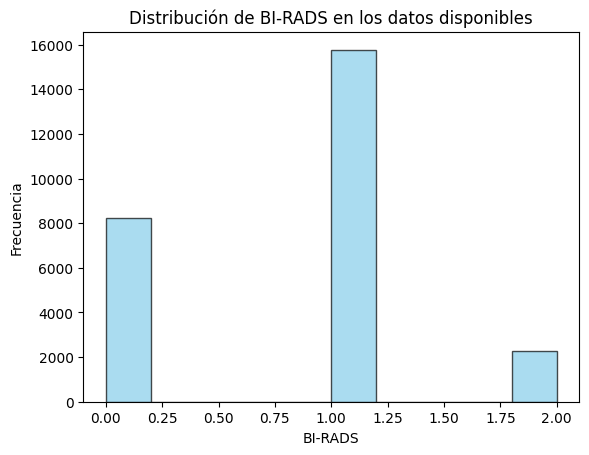

In [7]:
# Analizar la distribución existente
plt.hist(birads, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribución de BI-RADS en los datos disponibles')
plt.xlabel('BI-RADS')
plt.ylabel('Frecuencia')
plt.show()

**Analisis distribución**
- La categoría 1.0 es la más prevalente, con más de 16,000 registros.
- La categoría 0.0 también tiene una representación considerable, con alrededor de 8,000 registros.
- La categoría 2.0 tiene la menor cantidad de registros, en comparación con las otras dos.

**Simulación de montecarlo básica para valores faltantes**

1. calcular las probabilidades de cada categoría de BI-RADS (0, 1, 2) con base en su frecuencia relativa en los datos disponibles.
2. Usar estas probabilidades para imputar valores faltantes de manera aleatoria, manteniendo las proporciones observadas en los datos originales.

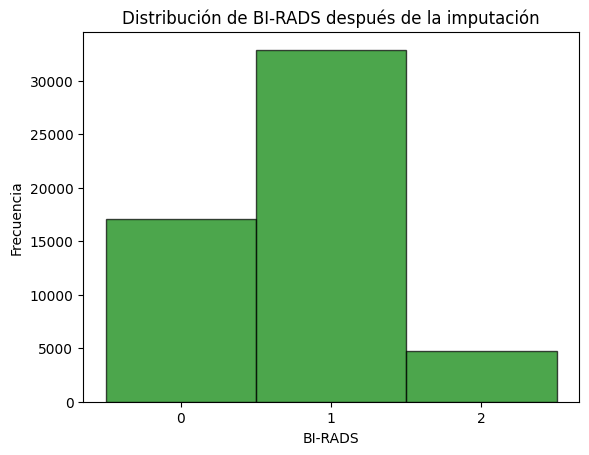

In [8]:
# Calcular las probabilidades dinámicamente
available_birads = train_df['BIRADS'].dropna()  # Valores disponibles
birads_probs = available_birads.value_counts(normalize=True).sort_index().to_list()

# Función para simular valores faltantes
def simulate_categorical_birads(size, probs):
    categories = [0, 1, 2]  # Los valores posibles de BI-RADS
    simulated_values = np.random.choice(categories, size=size, p=probs)
    return simulated_values

np.random.seed(42)  # Para reproducibilidad

# Identificar los índices con valores faltantes
missing_indices = train_df[train_df['BIRADS'].isnull()].index
num_missing = len(missing_indices)

# Simular los valores faltantes usando las probabilidades dinámicas
simulated_birads = simulate_categorical_birads(num_missing, birads_probs)

# Imputar los valores simulados
train_df.loc[missing_indices, 'BIRADS'] = simulated_birads

# Visualizar la distribución después de la imputación
plt.hist(train_df['BIRADS'], bins=[-0.5, 0.5, 1.5, 2.5], color='green', edgecolor='black', alpha=0.7)
plt.xticks([0, 1, 2])
plt.title('Distribución de BI-RADS después de la imputación')
plt.xlabel('BI-RADS')
plt.ylabel('Frecuencia')
plt.show()

**Distribución después de la imputación:**

- La distribución se ajusta a las proporciones originales calculadas antes de la imputación:
- La categoría 1.0 sigue siendo la más prevalente.
- Las categorías 0.0 y 2.0 tienen menor representación, como en los datos originales.

Este método asume que los valores faltantes son completamente aleatorios y que su distribución sigue las probabilidades observadas. 

In [9]:
# Comparar distribuciones
original_distribution = available_birads.value_counts(normalize=True).sort_index()
imputed_distribution = train_df['BIRADS'].value_counts(normalize=True).sort_index()

comparison = pd.DataFrame({
    'Original': original_distribution,
    'Imputed': imputed_distribution
})
print(comparison)

        Original   Imputed
BIRADS                    
0.0     0.313817  0.312690
1.0     0.600015  0.601122
2.0     0.086168  0.086188


Validación de nulos en variable densidad

In [10]:
# Ver valores únicos y frecuencias
print(train_df['density'].value_counts())

density
B    12651
C    12175
A     3105
D     1539
Name: count, dtype: int64


In [11]:
#Cálculo de las probabilidades dinamicamente
# Filtrar los datos disponibles
available_density = train_df['density'].dropna()

# Calcular las frecuencias relativas
density_probs = available_density.value_counts(normalize=True).sort_index().to_list()
print(f"Probabilidades calculadas dinámicamente: {density_probs}")

Probabilidades calculadas dinámicamente: [0.10536138445877163, 0.4292840176450628, 0.41313199864268746, 0.052222599253478115]


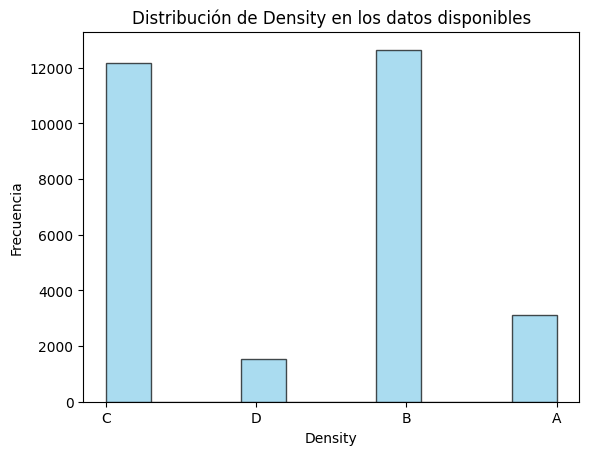

In [12]:
# Analizar la distribución existente
plt.hist(available_density, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribución de Density en los datos disponibles')
plt.xlabel('Density')
plt.ylabel('Frecuencia')
plt.show()

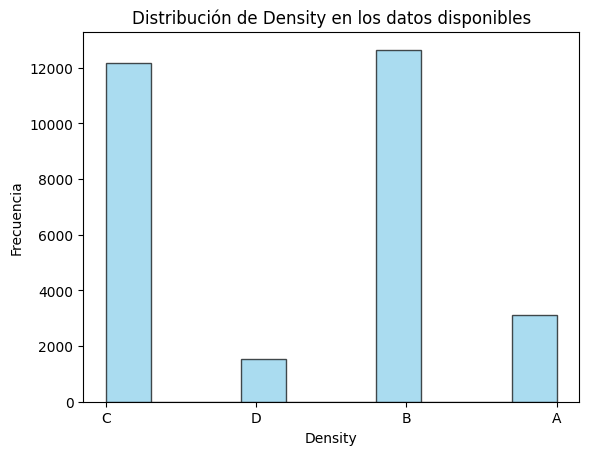

In [13]:
# Analizar la distribución existente
plt.hist(available_density, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribución de Density en los datos disponibles')
plt.xlabel('Density')
plt.ylabel('Frecuencia')
plt.show()

In [14]:
#Validamos la imputación
# Distribuciones original e imputada
original_density_distribution = available_density.value_counts(normalize=True).sort_index()
imputed_density_distribution = train_df['density'].value_counts(normalize=True).sort_index()

# Crear comparación
density_comparison = pd.DataFrame({
    'Original': original_density_distribution,
    'Imputed': imputed_density_distribution
})
print(density_comparison)

         Original   Imputed
density                    
A        0.105361  0.105361
B        0.429284  0.429284
C        0.413132  0.413132
D        0.052223  0.052223


cancer
0    53548
1     1158
Name: count, dtype: int64


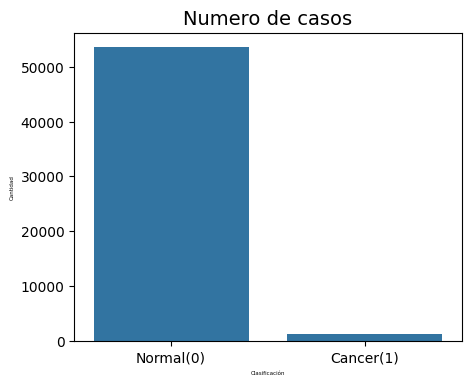

In [15]:
cases_count = train_df['cancer'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(5,4))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Numero de casos', fontsize=14)
plt.xlabel('Clasificación', fontsize=4)
plt.ylabel('Cantidad', fontsize=4)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Cancer(1)'])
plt.show()

**Visualización del conjunto de imagenes:**

Primera fila imagenes con cancer
Segunda fila imegenes sin cancer

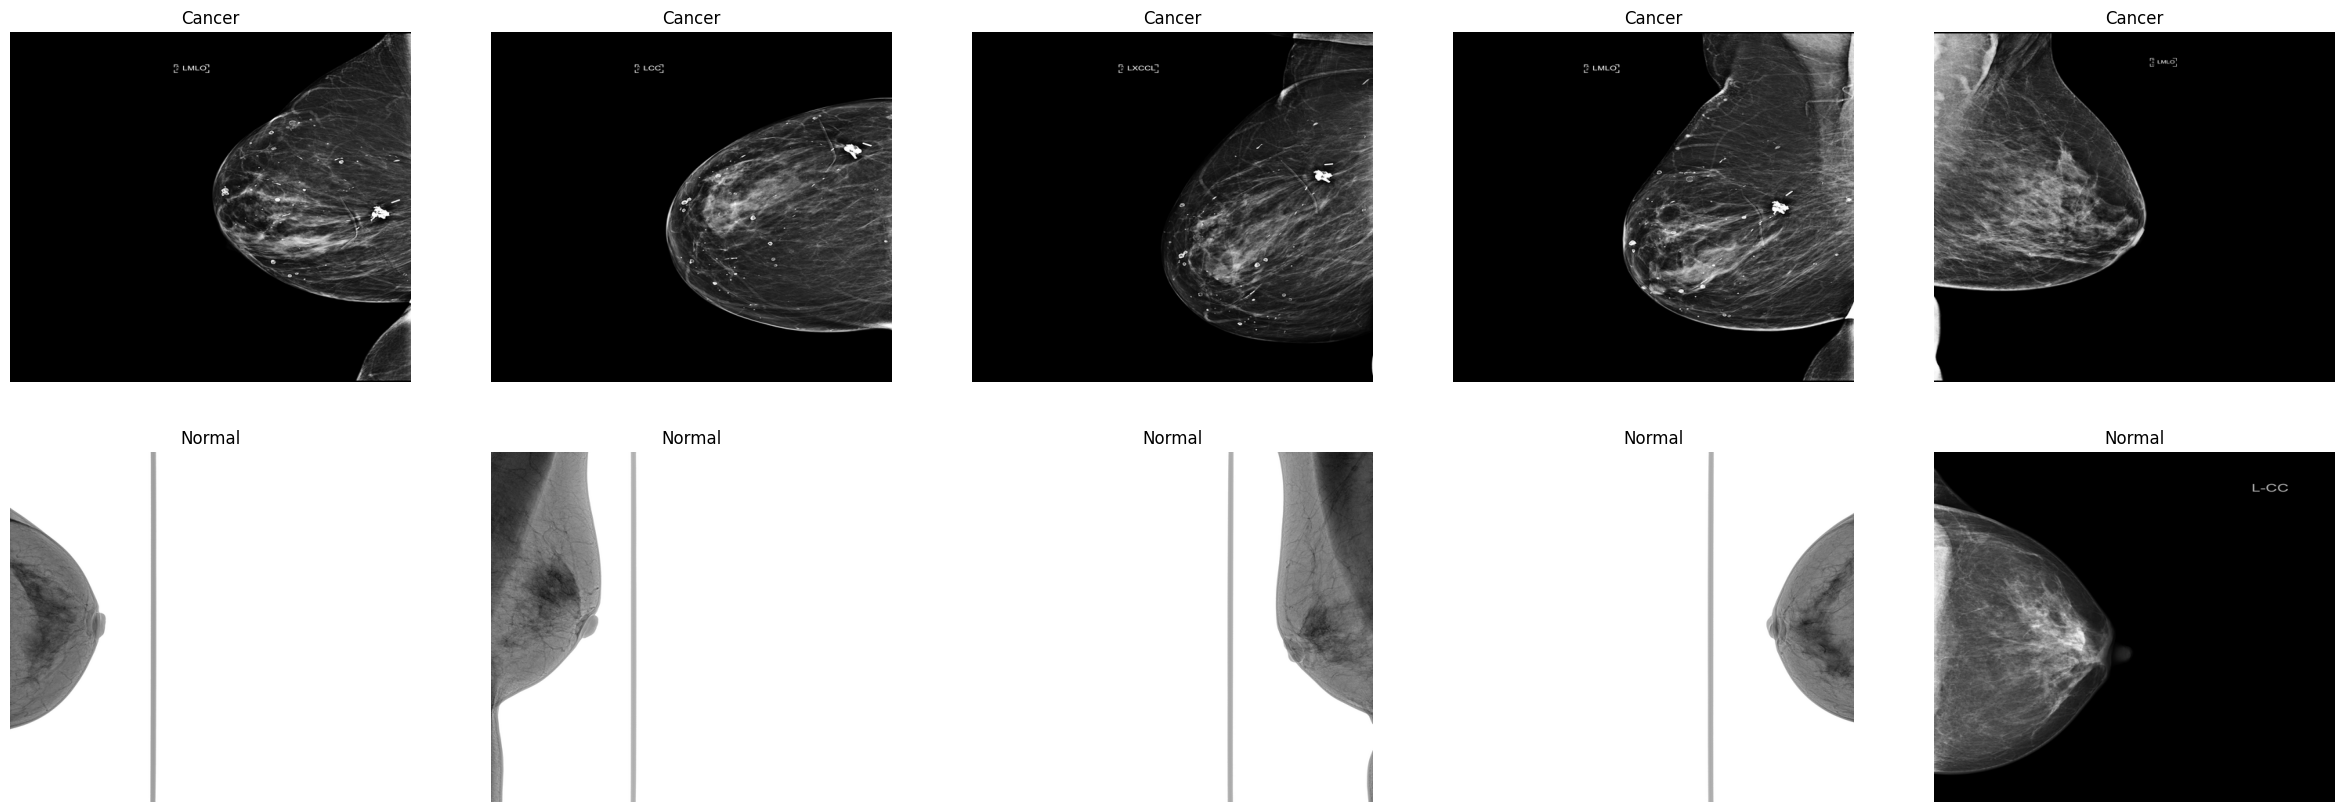

In [16]:
#Visualizar imagenes clasificadas con cancer y no cancer
Cancer_samples = (train_df[train_df['cancer']==1]['img_path'].iloc[0:5]).tolist()
Normal_samples = (train_df[train_df['cancer']==0]['img_path'].iloc[0:5]).tolist()

samples = Cancer_samples + Normal_samples

f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = tf.keras.preprocessing.image.load_img(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Cancer")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

Histogramas de pacientes con y sin cancer para visualizar distribución, media, mediana, minimo y maximo por tipo de diagnostico

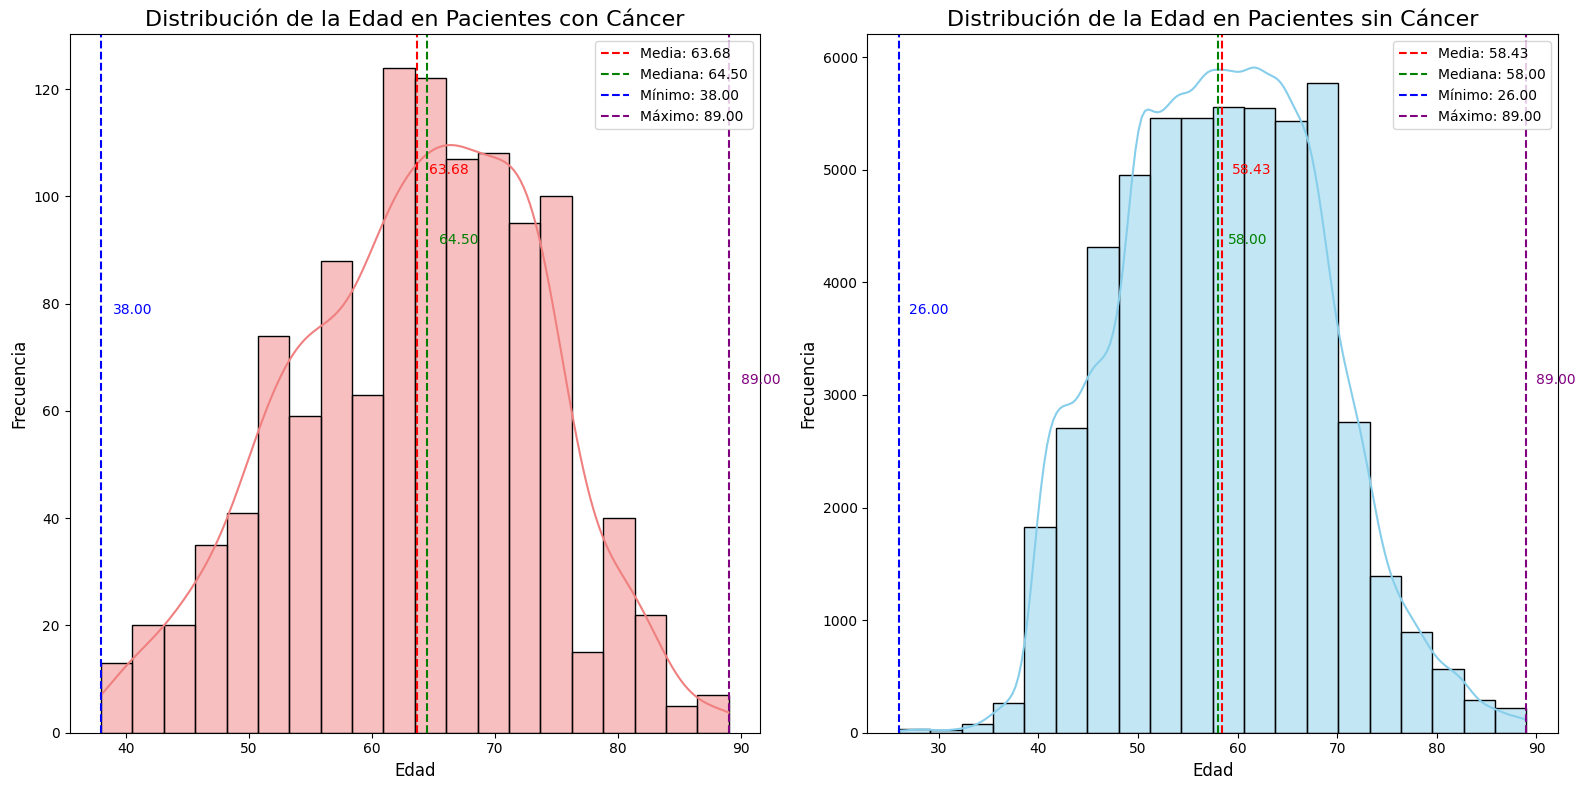

In [17]:
# Separar los datos entre pacientes con cáncer y sin cáncer
cancer_df = train_df[train_df['cancer'] == 1]
no_cancer_df = train_df[train_df['cancer'] == 0]

# Crear una figura con dos gráficos (uno para cáncer, otro para no cáncer)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# --- Gráfico para pacientes con cáncer ---
sns.histplot(cancer_df['age'], kde=True, bins=20, color='lightcoral', edgecolor='black', ax=axes[0])

# Calcular estadísticos para pacientes con cáncer
mean_age_cancer = cancer_df['age'].mean()
median_age_cancer = cancer_df['age'].median()
min_age_cancer = cancer_df['age'].min()
max_age_cancer = cancer_df['age'].max()

# Añadir líneas de estadísticos
axes[0].axvline(mean_age_cancer, color='red', linestyle='--', label=f'Media: {mean_age_cancer:.2f}')
axes[0].axvline(median_age_cancer, color='green', linestyle='--', label=f'Mediana: {median_age_cancer:.2f}')
axes[0].axvline(min_age_cancer, color='blue', linestyle='--', label=f'Mínimo: {min_age_cancer:.2f}')
axes[0].axvline(max_age_cancer, color='purple', linestyle='--', label=f'Máximo: {max_age_cancer:.2f}')
# Añadir anotaciones
axes[0].text(mean_age_cancer + 1, axes[0].get_ylim()[1] * 0.8, f'{mean_age_cancer:.2f}', color='red')
axes[0].text(median_age_cancer + 1, axes[0].get_ylim()[1] * 0.7, f'{median_age_cancer:.2f}', color='green')
axes[0].text(min_age_cancer + 1, axes[0].get_ylim()[1] * 0.6, f'{min_age_cancer:.2f}', color='blue')
axes[0].text(max_age_cancer + 1, axes[0].get_ylim()[1] * 0.5, f'{max_age_cancer:.2f}', color='purple')

# Título y etiquetas para pacientes con cáncer
axes[0].set_title('Distribución de la Edad en Pacientes con Cáncer', fontsize=16)
axes[0].set_xlabel('Edad', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].legend()

# --- Gráfico para pacientes sin cáncer ---
sns.histplot(no_cancer_df['age'], kde=True, bins=20, color='skyblue', edgecolor='black', ax=axes[1])

# Calcular estadísticos para pacientes sin cáncer
mean_age_no_cancer = no_cancer_df['age'].mean()
median_age_no_cancer = no_cancer_df['age'].median()
min_age_no_cancer = no_cancer_df['age'].min()
max_age_no_cancer = no_cancer_df['age'].max()
# Añadir líneas de estadísticos
axes[1].axvline(mean_age_no_cancer, color='red', linestyle='--', label=f'Media: {mean_age_no_cancer:.2f}')
axes[1].axvline(median_age_no_cancer, color='green', linestyle='--', label=f'Mediana: {median_age_no_cancer:.2f}')
axes[1].axvline(min_age_no_cancer, color='blue', linestyle='--', label=f'Mínimo: {min_age_no_cancer:.2f}')
axes[1].axvline(max_age_no_cancer, color='purple', linestyle='--', label=f'Máximo: {max_age_no_cancer:.2f}')

# Añadir anotaciones
axes[1].text(mean_age_no_cancer + 1, axes[1].get_ylim()[1] * 0.8, f'{mean_age_no_cancer:.2f}', color='red')
axes[1].text(median_age_no_cancer + 1, axes[1].get_ylim()[1] * 0.7, f'{median_age_no_cancer:.2f}', color='green')
axes[1].text(min_age_no_cancer + 1, axes[1].get_ylim()[1] * 0.6, f'{min_age_no_cancer:.2f}', color='blue')
axes[1].text(max_age_no_cancer + 1, axes[1].get_ylim()[1] * 0.5, f'{max_age_no_cancer:.2f}', color='purple')

# Título y etiquetas para pacientes sin cáncer
axes[1].set_title('Distribución de la Edad en Pacientes sin Cáncer', fontsize=16)
axes[1].set_xlabel('Edad', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].legend()
# Mostrar el gráfico
plt.tight_layout()
plt.show()

**Matriz de correlación**

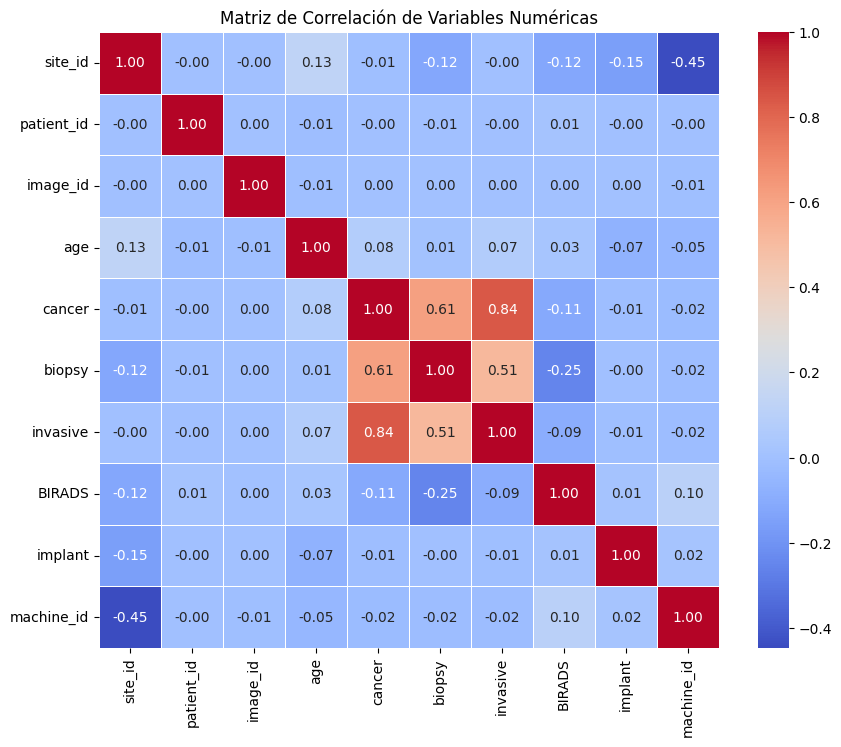

In [18]:
# Seleccionar solo las columnas numéricas del DataFrame
numeric_df = train_df.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
corr_matrix = numeric_df.corr()

# Crear el gráfico de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

* Las correlaciones fuertes entre cancer, invasive, y biopsy confirman su estrecha relación clínica. Esto implica que estas variables están alineadas con el flujo normal del diagnóstico y tratamiento del cáncer.

* La correlación negativa moderada entre BI-RADS y biopsy destaca el valor de BI-RADS como un predictor inicial para decidir pruebas adicionales.

* La relación entre site_id y machine_id sugiere diferencias entre los sitios en términos de tecnología o metodología, que podrían introducir sesgos en los datos. 

C:\Users\Melissa\AppData\Local\Temp\ipykernel_26040\3099771393.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cancer', y='age', data=train_df, palette=['blue', 'red'])


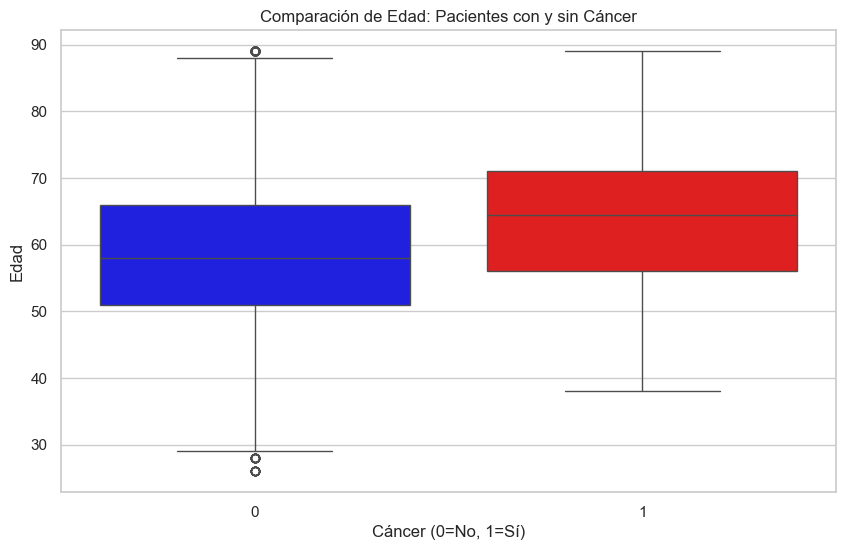

In [19]:
# Filtrar los pacientes con cáncer y sin cáncer
cancer_patients = train_df[train_df['cancer'] == 1]
no_cancer_patients = train_df[train_df['cancer'] == 0]

# Configurar estilo visual
sns.set(style="whitegrid")

# Boxplot para comparar las distribuciones de edad
plt.figure(figsize=(10, 6))
sns.boxplot(x='cancer', y='age', data=train_df, palette=['blue', 'red'])
plt.title('Comparación de Edad: Pacientes con y sin Cáncer')
plt.xlabel('Cáncer (0=No, 1=Sí)')
plt.ylabel('Edad')
plt.show()

**Pacientes sin cáncer (Cáncer = 0, barra azul):**

* Rango intercuartílico (IQR): La mayoría de los pacientes tienen edades entre aproximadamente 52 y 65 años.
* Mediana: Alrededor de los 58 años.
* Rango completo: Los pacientes sin cáncer tienen edades que van desde los 30 hasta los 89 años, con algunos outliers menores por debajo de los 40 años.

**Pacientes con cáncer (Cáncer = 1, barra roja):**

* Rango intercuartílico (IQR): La mayoría de los pacientes tienen edades entre aproximadamente 60 y 70 años.
* Mediana: Alrededor de los 65 años, notablemente mayor que para los pacientes sin cáncer.
* Rango completo: Los pacientes con cáncer también tienen edades entre 30 y 89 años, pero con un rango ligeramente desplazado hacia valores más altos.

* Existe una clara diferencia en la distribución de edad entre los dos grupos, con los pacientes con cáncer tendiendo a ser mayores.
* Esto es consistente con el conocimiento médico: el riesgo de cáncer generalmente aumenta con la edad debido a factores acumulativos como mutaciones celulares y cambios hormonales.
* La variable age puede ser un predictor útil para modelos de clasificación, ya que muestra diferencias notables entre los dos grupos.

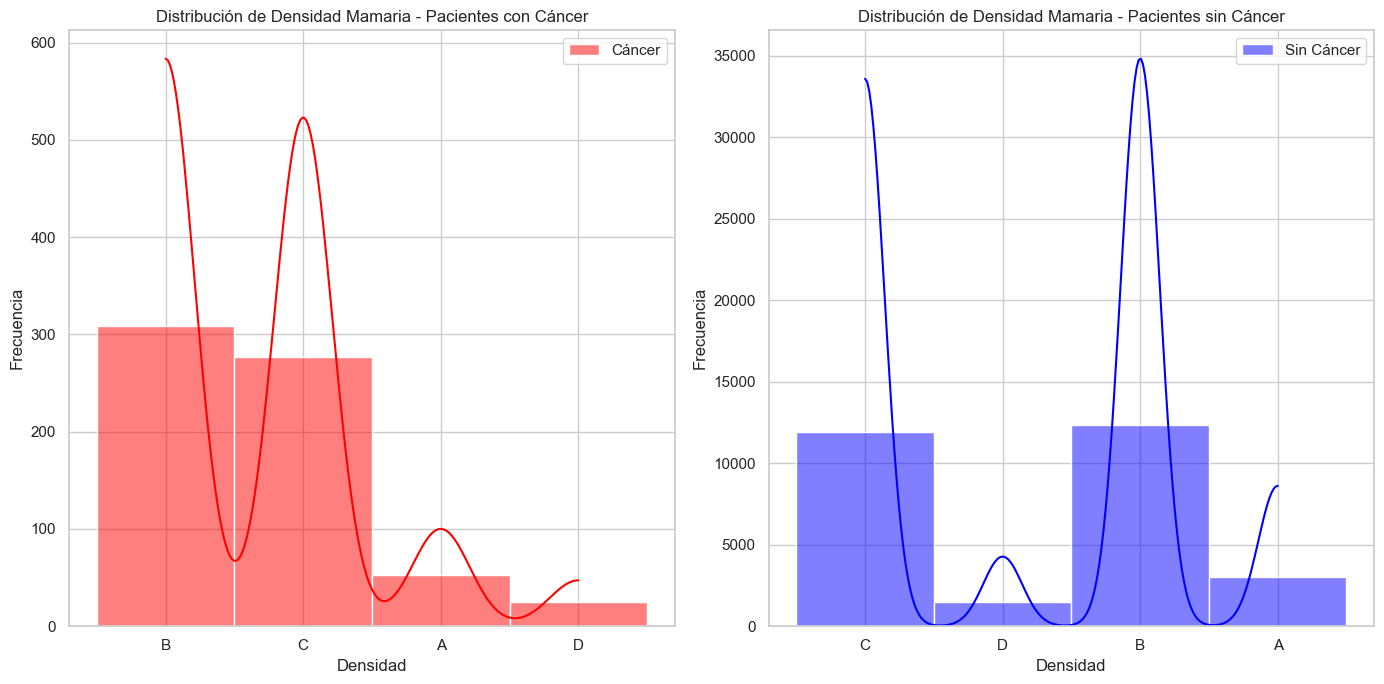

In [20]:
# Histograma para visualizar la distribución de la densidad
plt.figure(figsize=(14, 7))

# Densidad en pacientes con cáncer
plt.subplot(1, 2, 1)
sns.histplot(cancer_patients['density'], kde=True, bins=20, color='red', label='Cáncer')
plt.title('Distribución de Densidad Mamaria - Pacientes con Cáncer')
plt.xlabel('Densidad')
plt.ylabel('Frecuencia')
plt.legend()

# Densidad en pacientes sin cáncer
plt.subplot(1, 2, 2)
sns.histplot(no_cancer_patients['density'], kde=True, bins=20, color='blue', label='Sin Cáncer')
plt.title('Distribución de Densidad Mamaria - Pacientes sin Cáncer')
plt.xlabel('Densidad')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()

**Pacientes con cáncer (gráfico izquierdo, color rojo):**

+ Densidad B: Es la más prevalente en este grupo, con una frecuencia alta.
+ Densidad C: También es común, aunque en menor proporción que la densidad B.
+ Densidades A y D: Tienen una representación mucho menor, siendo la densidad D la menos común.

**Pacientes sin cáncer (gráfico derecho, color azul):**

+ Densidad B y C: Ambas tienen una representación notable, pero la densidad C es más prevalente en este grupo, a diferencia de los pacientes con cáncer.
+ Densidades A y D: Siguen siendo menos frecuentes, pero la densidad A es ligeramente más común aquí que en los pacientes con cáncer.

Densidad B:
- Más prevalente entre pacientes con cáncer, lo que podría sugerir una relación entre esta densidad y el diagnóstico de cáncer.

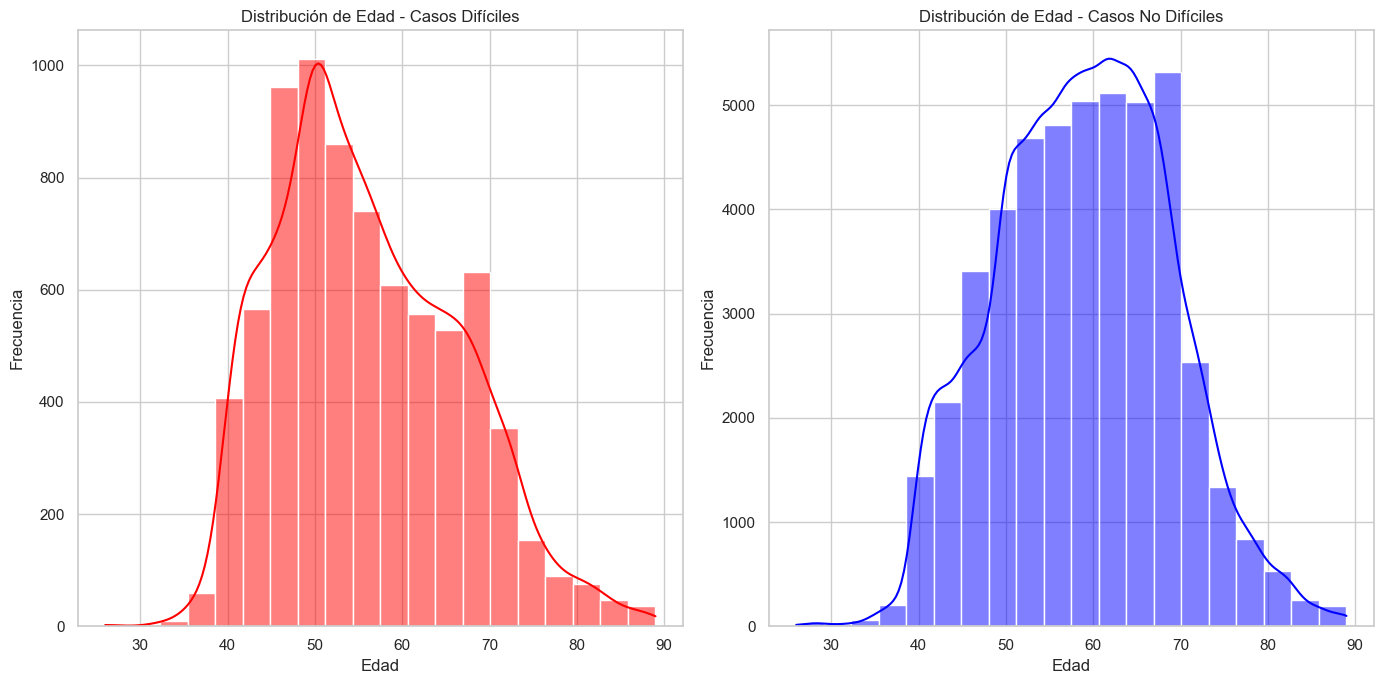

C:\Users\Melissa\AppData\Local\Temp\ipykernel_26040\825165943.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=difficult_cases, x='view', palette='Reds')
C:\Users\Melissa\AppData\Local\Temp\ipykernel_26040\825165943.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=non_difficult_cases, x='view', palette='Blues')


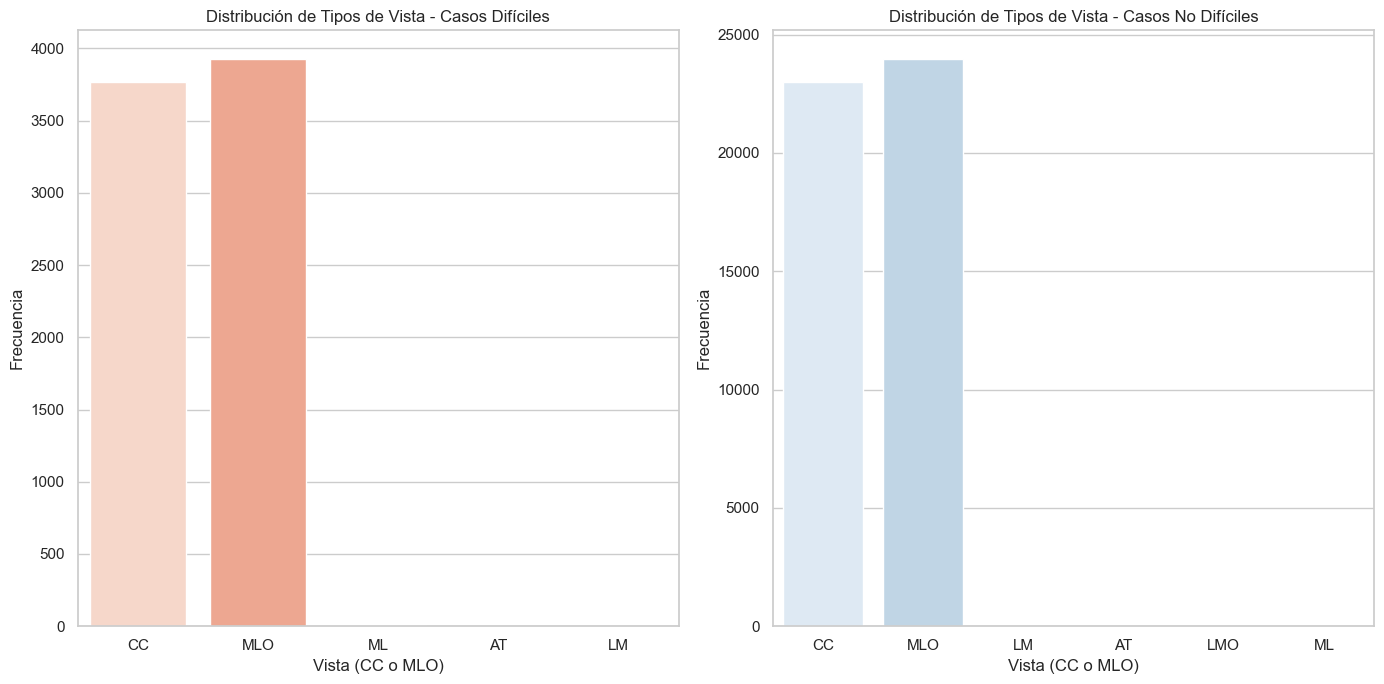

In [21]:
# Filtrar casos difíciles y no difíciles
difficult_cases = train_df[train_df['difficult_negative_case'] == True]
non_difficult_cases = train_df[train_df['difficult_negative_case'] == False]

# Configurar estilo visual
sns.set(style="whitegrid")

# Comparar la edad en casos difíciles y no difíciles
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.histplot(difficult_cases['age'], kde=True, bins=20, color='red', label='Difícil')
plt.title('Distribución de Edad - Casos Difíciles')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
sns.histplot(non_difficult_cases['age'], kde=True, bins=20, color='blue', label='No Difícil')
plt.title('Distribución de Edad - Casos No Difíciles')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Comparar el tipo de vista en casos difíciles y no difíciles
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.countplot(data=difficult_cases, x='view', palette='Reds')
plt.title('Distribución de Tipos de Vista - Casos Difíciles')
plt.xlabel('Vista (CC o MLO)')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
sns.countplot(data=non_difficult_cases, x='view', palette='Blues')
plt.title('Distribución de Tipos de Vista - Casos No Difíciles')
plt.xlabel('Vista (CC o MLO)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

**Casos difíciles (gráfico izquierdo):**

- Distribución:
    - Tiene un pico (moda) alrededor de los 50 años.
    - Hay una concentración considerable entre los 45 y 55 años, con un declive gradual hacia edades mayores y menores.
- Rango de edad:
    - La mayoría de los casos se encuentran entre 40 y 70 años.
    - Los casos difíciles son menos comunes en edades menores a 40 y mayores a 75 años.

**Casos no difíciles(gráfico derecho):**

- Distribución:
    - Tiene un pico (moda) alrededor de los 65 años, mostrando un desplazamiento hacia edades mayores en comparación con los casos difíciles.
    - Hay una distribución más amplia en el rango de edad entre 50 y 70 años, lo que sugiere que los casos no difíciles abarcan una población más diversa en términos de edad.
- Rango de edad:
    - La mayoría de los casos se concentran entre los 50 y 75 años, con una representación más notable en edades mayores (70+).

**Casos difíciles (izquierda, color rojo):**

- Proyecciones CC (Cranio-Caudal):
    - Frecuencia ligeramente menor que MLO.
    - Representa alrededor del 48% de las vistas en los casos difíciles.
- Proyecciones MLO (Medio-Lateral Oblicua):
    - Es la más común entre los casos difíciles, con una ligera ventaja sobre CC.
    - Representa aproximadamente el 52% de las vistas.
- Otras vistas (ML, AT, LM, LMO):
    - No tienen representación en los casos difíciles, lo que implica que estas vistas no se utilizan o no están presentes en este conjunto para estos casos.

**Casos no difíciles (derecha, color azul):**

- Proyecciones CC:
    - Similar a los casos difíciles, CC representa una proporción significativa pero ligeramente menor que MLO.
- Proyecciones MLO:
    - Es la vista más frecuente, representando un porcentaje mayor en comparación con CC.
- Otras vistas (ML, AT, LM, LMO):
    - Estas vistas tampoco están presentes en los casos no difíciles.

- La mayoría de las mamografías en este conjunto de datos utilizan vistas estándar (CC y MLO). Esto es consistente con la práctica clínica, donde estas vistas son las más comunes para evaluar el tejido mamario.
- La vista MLO es la más frecuente en ambos grupos (casos difíciles y no difíciles). Esto podría deberse a que proporciona una mejor visualización de la parte superior y lateral del tejido mamario, lo cual es importante tanto para evaluaciones rutinarias como para casos complejos.
- La distribución entre CC y MLO es muy similar para ambos grupos, lo que indica que la dificultad del caso no parece estar relacionada con el tipo de vista utilizada.

## Reducción del conjunto de datos y balanceo de clases

In [22]:
minority_class_size = train_df['cancer'].value_counts().min()

# Definir la proporción de muestras de la clase mayoritaria (ejemplo: 2 veces la clase minoritaria)
majority_class_multiplier = 10
majority_class_size = minority_class_size * majority_class_multiplier

# Obtener todas las muestras de la clase minoritaria
minority_samples = train_df[train_df['cancer'] == 1]

# Obtener una muestra aleatoria de la clase mayoritaria
majority_samples = train_df[train_df['cancer'] == 0].sample(majority_class_size, random_state=42)

# Combinar las muestras de ambas clases
balanced_df = pd.concat([minority_samples, majority_samples]).sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar el balance de clases
print(balanced_df['cancer'].value_counts())

cancer
0    11580
1     1158
Name: count, dtype: int64


El conjunto de datos inicial era muy grande, lo que podía generar problemas de rendimiento en el entrenamiento del modelo (como mayor tiempo de procesamiento o uso excesivo de recursos). Además, la variable objetivo (cancer) estaba desbalanceada, con una cantidad mucho mayor de muestras de la clase 0 (sin cáncer) frente a la clase 1 (con cáncer). Para solucionar esto:

1. Se calcula el tamaño de la clase minoritaria (minority_class_size) para establecer un punto de referencia.
2. Se incluye 10 veces más muestras de la clase mayoritaria (cancer = 0) que de la clase minoritaria (cancer = 1), ajustando el tamaño total del conjunto.
3. Se extraen todas las muestras de la clase minoritaria (minority_samples).
4. Se toma una muestra aleatoria de la clase mayoritaria (majority_samples) de tamaño proporcional a la clase minoritaria, utilizando un generador de números aleatorios para garantizar reproducibilidad (random_state=42).
5. Se unen las muestras seleccionadas de ambas clases para crear un nuevo conjunto de datos balanceado y reducido.
6. Se reordenan las muestras aleatoriamente para evitar patrones específicos en el orden de las filas.

## Procesamiento Digital de Imagenes

El procesamiento digital de imágenes (PDI) para mamografías es una herramienta esencial para mejorar la calidad de las imágenes, facilitar la detección de anomalías y ayudar a los radiólogos en el diagnóstico temprano de cáncer de mama. El objetivo principal del PDI en este contexto es mejorar el contraste, resaltar características relevantes y eliminar ruido, asegurando que las imágenes sean más claras y útiles para el análisis clínico. Por lo que se decide generar nuevas imagenes con mapas de calor para subrayar areas importantes de la mamografia con ayuda de un modelo preentrenado como VGG16

In [ ]:
# Cargar modelo una vez al inicio
model = VGG16(weights="imagenet") # Uso de modelo preentrenado VGG16 con los pesos de ImageNet.
grad_model = Model(inputs=model.inputs, outputs=[model.get_layer("block5_conv3").output, model.output]) # Se redefine la salida del modelo para incluir una capa intermedia (block5_conv3) y la salida final, lo que permite obtener tanto predicciones como gradientes.


In [ ]:
# Función para generar heatmap
def generate_heatmap(image_path):
    print("Generating heatmap")
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224)) #La imagen se carga, se redimensiona a 224x224 píxeles (requerido por VGG16) y se normaliza usando preprocess_input.
    img_array = np.expand_dims(img, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

    #Cálculo del mapa de calor
    with tf.GradientTape() as tape: #Usando GradientTape, se calcula el gradiente de la predicción de clase respecto a la capa intermedia seleccionada (block5_conv3).
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # Se ponderan los gradientes por los valores de activación de la capa y se reducen en el eje espacial para obtener un heatmap
    grads = tape.gradient(loss, conv_outputs)[0] #Gradientes
    weights = tf.reduce_mean(grads, axis=(0, 1)) #Pesos
    heatmap = tf.reduce_sum(weights * conv_outputs[0], axis=-1) #Ponderación y suma

    # Normalizar heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    if not isinstance(heatmap, np.ndarray):  # Si no es un array de NumPy, conviértelo
        heatmap = heatmap.numpy()
    heatmap = cv2.resize(heatmap, (512, 512))  # Redimensionar al tamaño original
    heatmap = (heatmap * 255).astype("uint8")
    return heatmap

# Superponer heatmap
def apply_heatmap(image_path, heatmap, alpha=0.6):
    print("Superponiendo heatmap")
    original_image = cv2.imread(image_path)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) #Se utiliza un colormap (esquema de color) para representar el heatmap en colores (cv2.COLORMAP_JET).
    overlay = cv2.addWeighted(heatmap_color, alpha, original_image, 1 - alpha, 0) #l heatmap se mezcla con la imagen original usando una opacidad definida (alpha=0.6), destacando las regiones relevantes.
    return overlay

# Función para procesar una imagen
def process_image(row):
    print("Guardando heatmap")
    input_path = row['img_path']
    output_dir = "images_processed_heatmap"  # Cambiar por tu ruta de salida
    os.makedirs(output_dir, exist_ok=True)
    
    try:
        heatmap = generate_heatmap(input_path)
        transformed_image = apply_heatmap(input_path, heatmap)

        # Generar salida en la misma estructura
        relative_path = os.path.relpath(input_path, start="train_images")
        output_path = os.path.join(output_dir, relative_path)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        cv2.imwrite(output_path, transformed_image)
        return f"Procesada: {output_path}"
    except Exception as e:
        return f"Error en {input_path}: {str(e)}"


In [ ]:
for _, row in balanced_df.iterrows():
    print(process_image(row))

Se actualiza el path de las imagenes apuntando a las imagenes con el heatmap supersupuesto

In [26]:
base_path='images_processed_heatmap'

# saving image path into train dataframe
balanced_df['img_path']= balanced_df.patient_id.astype(str)\
                    + '/' + balanced_df.image_id.astype(str)\
                    + '.png'



display(balanced_df.head(3))

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_path
0,1,65030,1344606626,L,MLO,56,0,0,0,1.0,0,B,49,False,65030/1344606626.png
1,2,31859,78460969,R,CC,68,0,0,0,1.0,0,NaN,48,False,31859/78460969.png
2,1,7098,786606520,R,CC,59,0,0,0,1.0,0,B,210,False,7098/786606520.png


# Modelo

In [ ]:
balanced_df['label'] = balanced_df['cancer']  # Usar 'cancer' como la etiqueta

# Dividir en conjuntos de entrenamiento y validación
train_df_mlo, val_df_mlo = train_test_split(balanced_df, test_size=0.2, random_state=42,stratify=balanced_df['label'] )

In [ ]:
# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, num_features, num_classes=2):
        super(CombinedModel, self).__init__()

        # Rama de imágenes: ResNet18 preentrenado
        self.resnet = resnet18(pretrained=True)
        num_resnet_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Eliminar la capa final para usar embeddings

        # Rama de características tabulares
        self.tabular_branch = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Capa combinada
        self.combined_branch = nn.Sequential(
            nn.Linear(num_resnet_features + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, image, features):
        # Procesar imágenes
        image_features = self.resnet(image)
        # Procesar características tabulares
        tabular_features = self.tabular_branch(features)
        # Combinar ambas ramas
        combined_features = torch.cat((image_features, tabular_features), dim=1)
        # Predicción final
        output = self.combined_branch(combined_features)

        return output


**Detalles del Modelo**
+ Inicialización del modelo (__init__):

    + Rama de imágenes:

        + Utiliza ResNet18 preentrenado en ImageNet para extraer embeddings (características latentes) de las imágenes.
        + Se reemplaza la capa final (fc) por nn.Identity() para mantener únicamente los embeddings de salida sin aplicar una predicción directa.
        + num_resnet_features almacena el tamaño de los embeddings producidos por ResNet18.

    + Rama de características tabulares:

        + Procesa datos tabulares con una secuencia de capas densas (2 capas Linear con activación ReLU y regularización con Dropout).
        + Toma como entrada num_features, que representa el número de características tabulares.

    + Capa combinada:

        + Combina los embeddings de imágenes y los de las características tabulares concatenándolos.
        + Pasa el resultado por una secuencia de capas densas (con ReLU y Dropout) antes de realizar la predicción final.

    + Método forward (propagación hacia adelante):

        + Procesa las imágenes a través de la rama de ResNet para extraer embeddings (image_features).
        + Procesa los datos tabulares a través de la rama de características tabulares (tabular_features).
        + Combina ambas representaciones (torch.cat) y las pasa por la capa combinada para generar la predicción final (output).

**Clase CombinedDataset:**

Esta clase permite manejar datos multimodales, es decir, datos que incluyen imágenes y características tabulares, además de etiquetas (labels) para una tarea supervisada, como clasificación. El propósito es combinar dos tipos de datos (imágenes y tabulares) en un único conjunto de datos para facilitar su uso

In [ ]:
class CombinedDataset(Dataset):
    def __init__(self, dataframe, img_dir, tabular_features, transform=None):
        self.dataframe = dataframe #Contiene la información general del dataset, como las rutas de las imágenes y las etiquetas.
        self.img_dir = img_dir #Es el directorio base donde se encuentran las imágenes.
        self.tabular_features = tabular_features #Un array o matriz (como un DataFrame o una lista) que contiene las características tabulares correspondientes a las imágenes.
        self.transform = transform #Transformaciones opcionales (por ejemplo, aumento de datos) que se aplican a las imágenes.

    def __len__(self):
        return len(self.dataframe) #Devuelve el número total de muestras en el conjunto de datos, definido por la longitud del dataframe.

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx] # Obtiene la fila correspondiente al índice
        img_path = os.path.join(self.img_dir, row['img_path']) # Ruta completa de la imagen
        label = row['label']  # Etiqueta: 1 para cáncer, 0 para no cáncer

        # Cargar y transformar imagen
        image = Image.open(img_path).convert('RGB') #Carga la imagen en formato RGB.
        if self.transform:
            image = self.transform(image) #Aplica las transformaciones definidas

        # Seleccionar características tabulares
        features = self.tabular_features[idx] #Selecciona las características tabulares correspondientes al índice.

        return image, torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        #Retorna: Imagen procesada (como un tensor), Características tabulares como un tensor flotante y Etiqueta como un tensor entero.


In [ ]:
# Normalizar características tabulares
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df_mlo[['age','biopsy', 'invasive', 'BIRADS']]) # Calcula los parámetros de escalado (media y desviación estándar) sobre las características de entrenamiento y aplica la transformación.
val_features = scaler.transform(val_df_mlo[['age','biopsy', 'invasive', 'BIRADS']]) # Utiliza los parámetros calculados en el conjunto de entrenamiento para transformar las características del conjunto de validación.

# Transformaciones de imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)), #Redimensiona las imágenes a 224x224 píxeles, que es el tamaño esperado por el modelo ResNet18.
    transforms.ToTensor(), #Convierte las imágenes a tensores PyTorch, cambiando su formato de [H, W, C] (alto, ancho, canales) a [C, H, W] (canales, alto, ancho).
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Normaliza las imágenes utilizando la media y desviación estándar de ImageNet (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ya que ResNet18 fue entrenado en este conjunto.
])

# Crear datasets y dataloaders
train_dataset = CombinedDataset(train_df_mlo, "images_processed_heatmap", train_features, transform=transform) #Se usa combinedDataset para unir las imágenes y las características tabulares en un único dataset.
val_dataset = CombinedDataset(val_df_mlo, "images_processed_heatmap", val_features, transform=transform)

#Dataloader = Permite cargar los datos en lotes (batches) durante el entrenamiento y validación.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# batch_size=64: Carga 64 muestras por lote.
# shuffle=True (entrenamiento): Baraja las muestras para mejorar el rendimiento del modelo al prevenir que aprenda un orden específico.
# shuffle=False (validación): Mantiene el orden para una evaluación consistente.


In [ ]:
#Visualización de matriz de confusión
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def validate_model(model, val_loader, criterion):
    model.eval()  # Modelo evaluar
    all_preds = [] # Para almacenar todas las predicciones
    all_labels = []  # Para almacenar todas las etiquetas verdaderas
    running_loss = 0.0  # Para acumular la pérdida

    with torch.no_grad(): #Se desactivan los cálculos de gradientes para ahorrar memoria y tiempo durante la evaluación.
        for images, features, labels in val_loader:
            images, features, labels = images.to(device), features.to(device), labels.to(device)

            # Forward
            outputs = model(images, features) # Propagación hacia adelante
            loss = criterion(outputs, labels) # Cálculo de la pérdida
            running_loss += loss.item() # Acumula la pérdida

            # Obtener predicciones 
            _, preds = torch.max(outputs, 1) # Obtiene la clase con mayor probabilidad
            all_preds.extend(preds.cpu().numpy()) # Almacena las predicciones
            all_labels.extend(labels.cpu().numpy()) # Almacena las etiquetas verdaderas

    # Calcular métricas
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Validation Loss: {running_loss / len(val_loader):.4f}")
    print(f"F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    plot_confusion_matrix(cm, ["No Cáncer", "Cáncer"])

    return f1


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, save_path="best_model.pth"):
    best_f1 = 0 #Se inicializa best_f1 para almacenar el mejor F1-Score observado durante la validación.
    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()
        running_loss = 0.0 #Se reinicia la pérdida acumulada (running_loss) al inicio de cada época.
        for images, features, labels in train_loader:
            images, features, labels = images.to(device), features.to(device), labels.to(device)

            # Forward y backward
            outputs = model(images, features) # Calcula las predicciones del modelo con las imágenes y características tabulares.
            loss = criterion(outputs, labels) # Utiliza la función de pérdida para calcular el error entre las predicciones y las etiquetas.
            optimizer.zero_grad() #Calcula los gradientes de los pesos con respecto a la pérdida.
            loss.backward()
            optimizer.step() #El optimizador actualiza los pesos del modelo con base en los gradientes.
            running_loss += loss.item() #Suma la pérdida de cada lote para calcular el promedio al final de la época.

        val_f1 = validate_model(model, val_loader, criterion)  # Asegúrate de que validate_model devuelva F1-Score
        print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader):.4f}") #Imprime la pérdida promedio del entrenamiento y la métrica de validación.

        # Guardar los mejores pesos del modelo
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), save_path)
            print(f"🔽 Model saved with F1-Score: {best_f1:.4f}")

        # Validación
        validate_model(model, val_loader, criterion)



c:\Users\Melissa\Ambientes\venv_integrador_2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Melissa\Ambientes\venv_integrador_2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Validation Loss: 0.0327
F1 Score: 0.9823, Precision: 0.9832, Recall: 0.9819


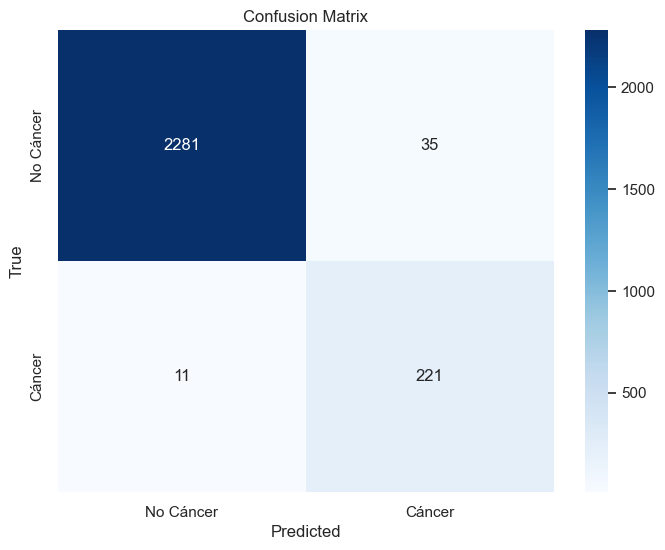

Epoch 1, Training Loss: 0.1026
🔽 Model saved with F1-Score: 0.9823
Validation Loss: 0.0327
F1 Score: 0.9823, Precision: 0.9832, Recall: 0.9819


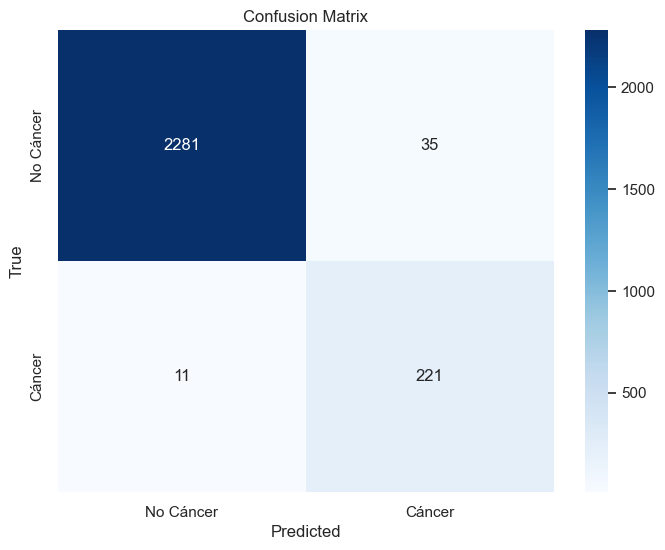

Validation Loss: 0.0320
F1 Score: 0.9814, Precision: 0.9819, Recall: 0.9812


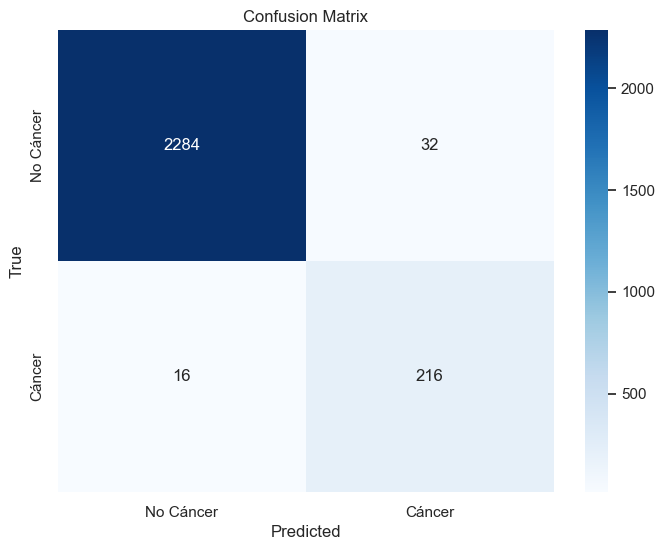

Epoch 2, Training Loss: 0.0430
Validation Loss: 0.0320
F1 Score: 0.9814, Precision: 0.9819, Recall: 0.9812


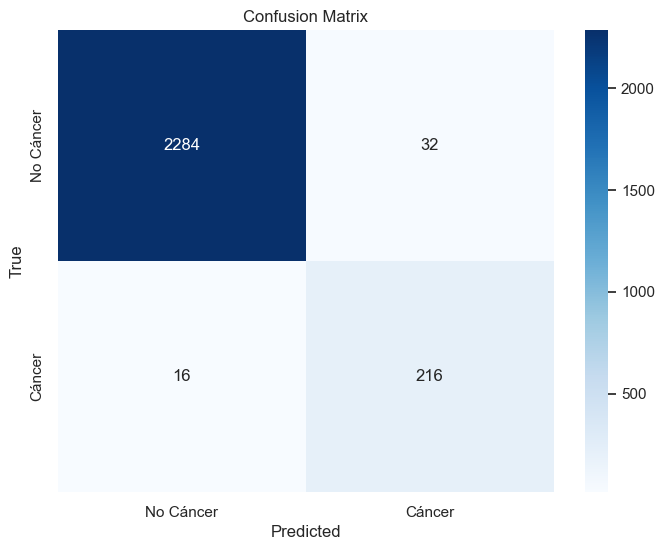

Validation Loss: 0.0293
F1 Score: 0.9838, Precision: 0.9844, Recall: 0.9835


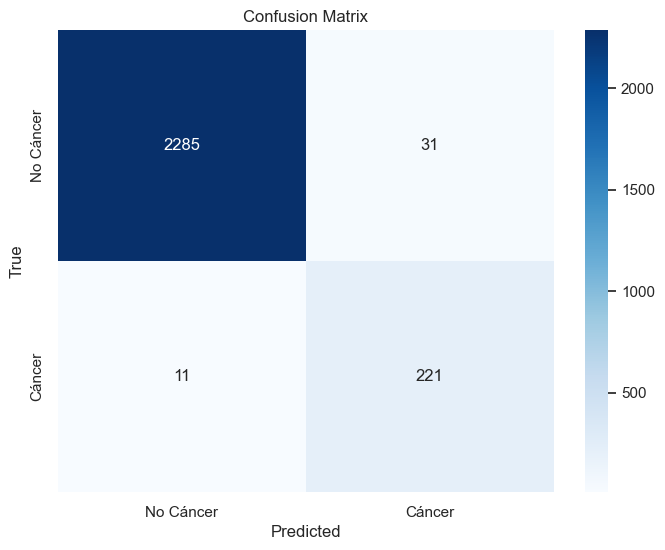

Epoch 3, Training Loss: 0.0387
🔽 Model saved with F1-Score: 0.9838
Validation Loss: 0.0293
F1 Score: 0.9838, Precision: 0.9844, Recall: 0.9835


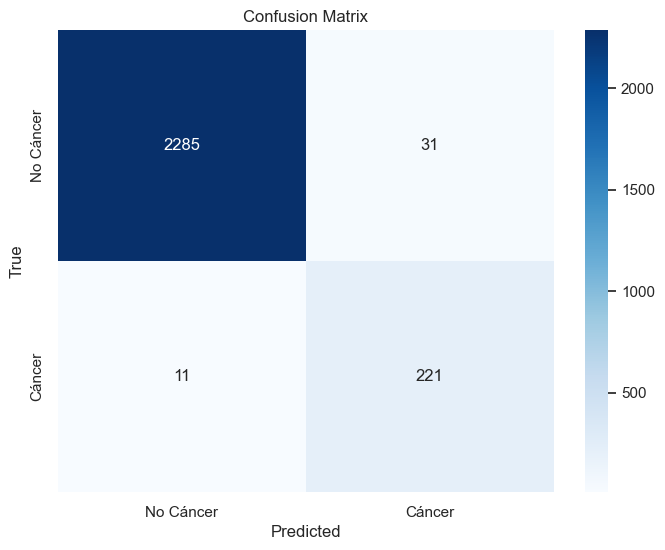

Validation Loss: 0.0326
F1 Score: 0.9799, Precision: 0.9816, Recall: 0.9792


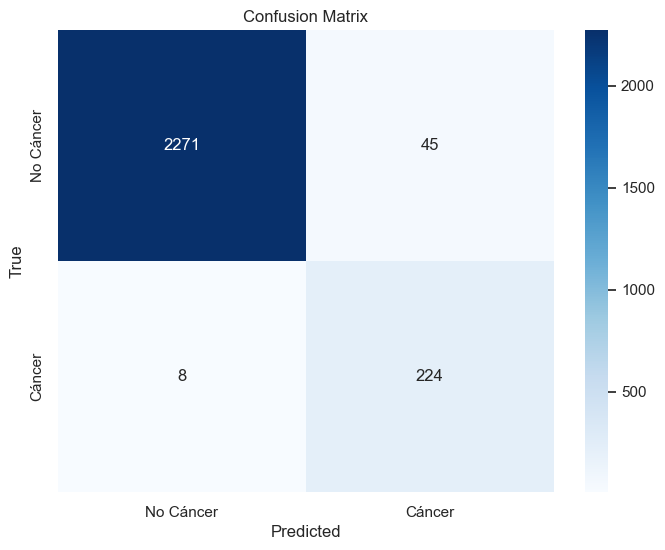

Epoch 4, Training Loss: 0.0391
Validation Loss: 0.0326
F1 Score: 0.9799, Precision: 0.9816, Recall: 0.9792


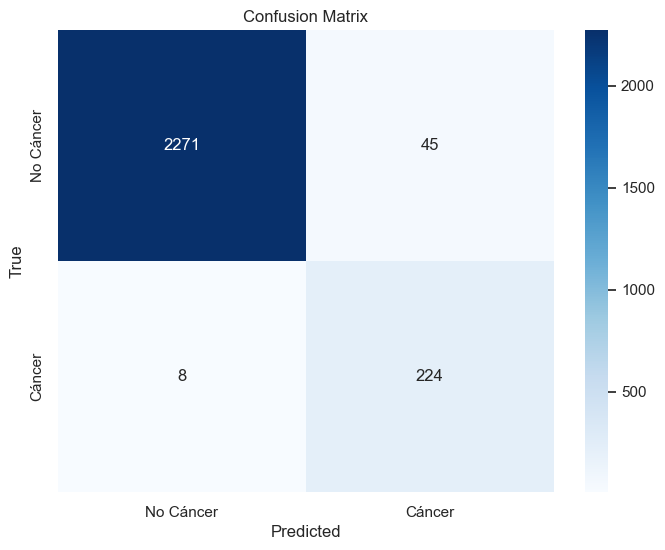

Validation Loss: 0.0307
F1 Score: 0.9833, Precision: 0.9837, Recall: 0.9831


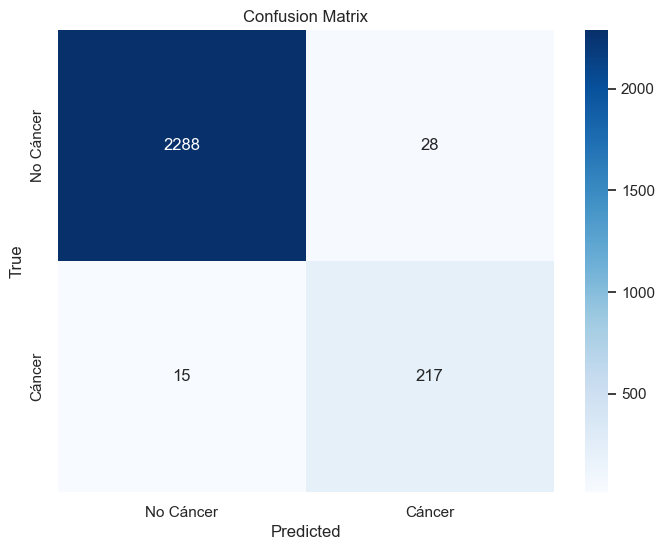

Epoch 5, Training Loss: 0.0375
Validation Loss: 0.0307
F1 Score: 0.9833, Precision: 0.9837, Recall: 0.9831


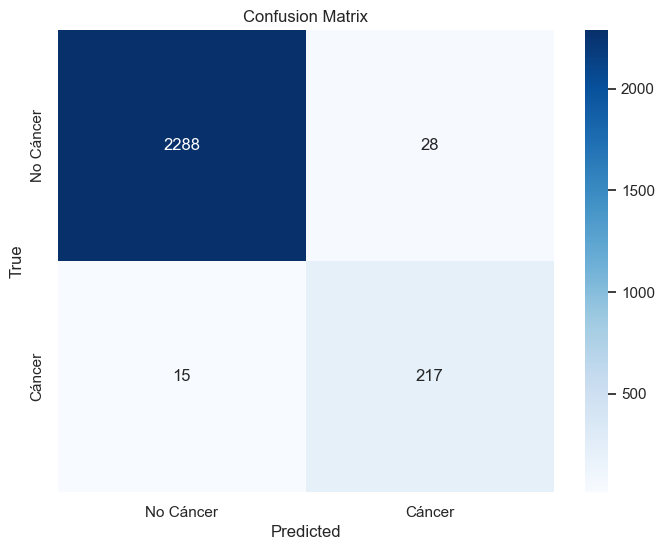

Validation Loss: 0.0291
F1 Score: 0.9848, Precision: 0.9849, Recall: 0.9851


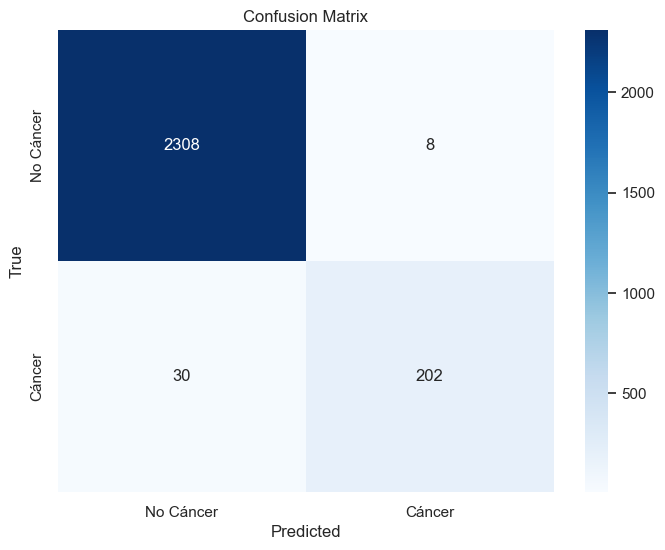

Epoch 6, Training Loss: 0.0374
🔽 Model saved with F1-Score: 0.9848
Validation Loss: 0.0291
F1 Score: 0.9848, Precision: 0.9849, Recall: 0.9851


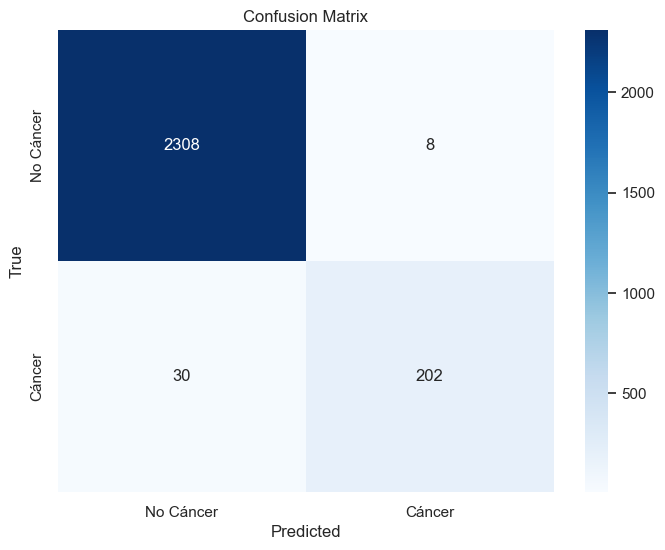

Validation Loss: 0.0311
F1 Score: 0.9838, Precision: 0.9838, Recall: 0.9839


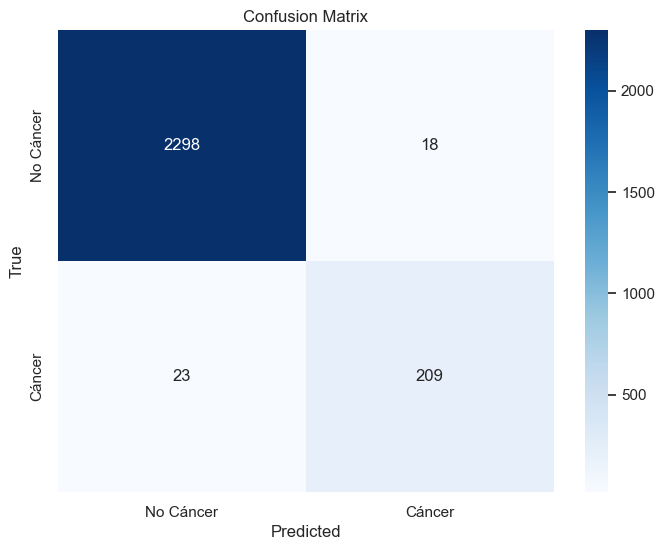

Epoch 7, Training Loss: 0.0368
Validation Loss: 0.0311
F1 Score: 0.9838, Precision: 0.9838, Recall: 0.9839


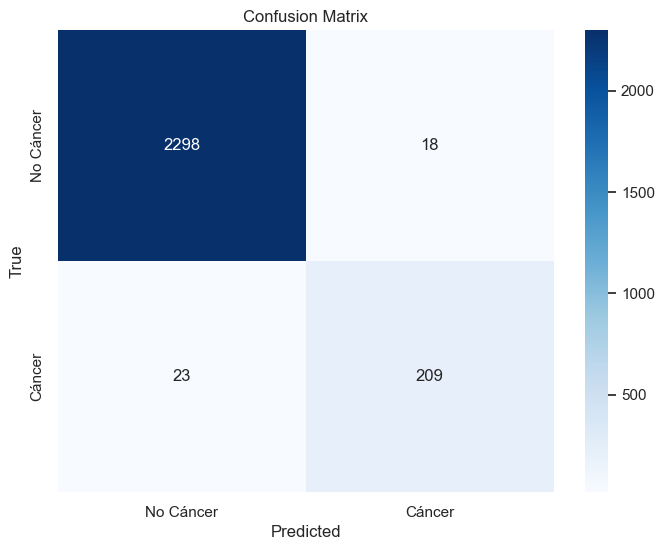

Validation Loss: 0.0320
F1 Score: 0.9838, Precision: 0.9842, Recall: 0.9843


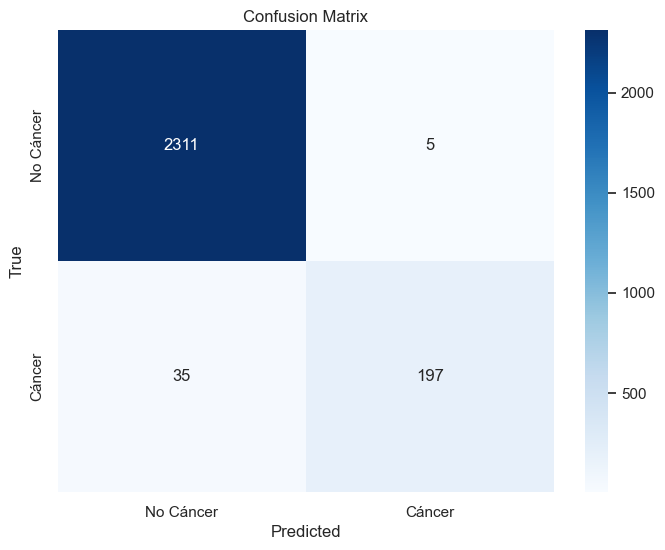

Epoch 8, Training Loss: 0.0363
Validation Loss: 0.0320
F1 Score: 0.9838, Precision: 0.9842, Recall: 0.9843


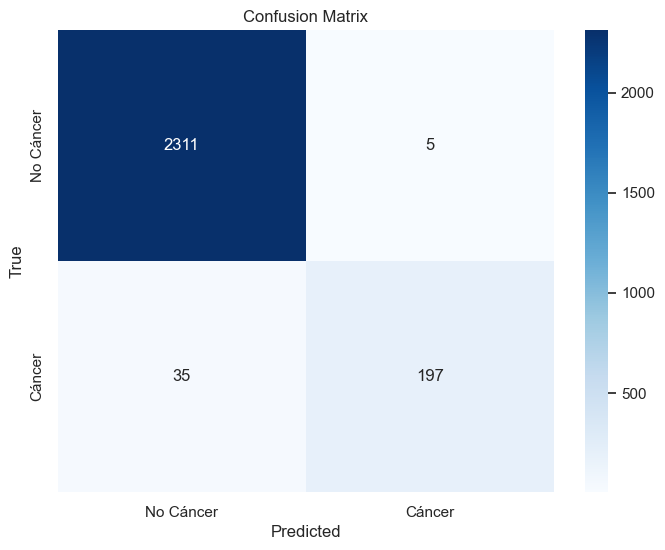

Validation Loss: 0.0304
F1 Score: 0.9837, Precision: 0.9841, Recall: 0.9835


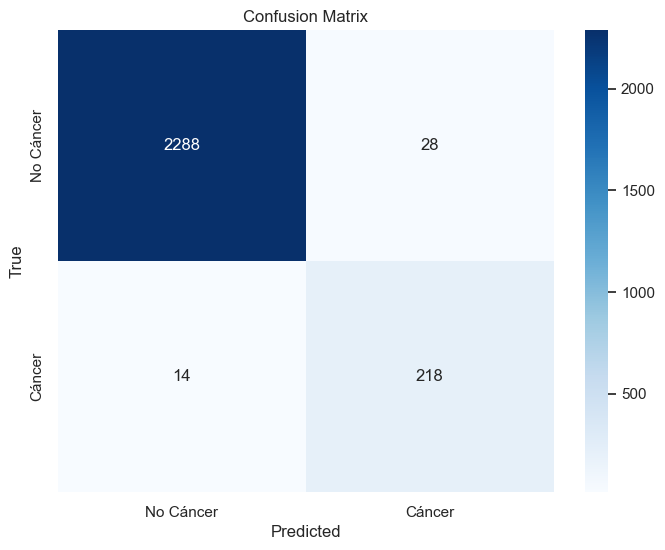

Epoch 9, Training Loss: 0.0364
Validation Loss: 0.0304
F1 Score: 0.9837, Precision: 0.9841, Recall: 0.9835


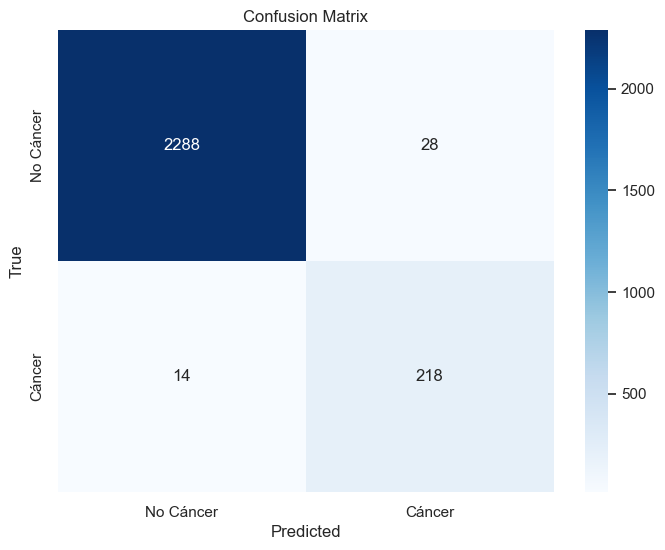

Validation Loss: 0.0313
F1 Score: 0.9816, Precision: 0.9827, Recall: 0.9812


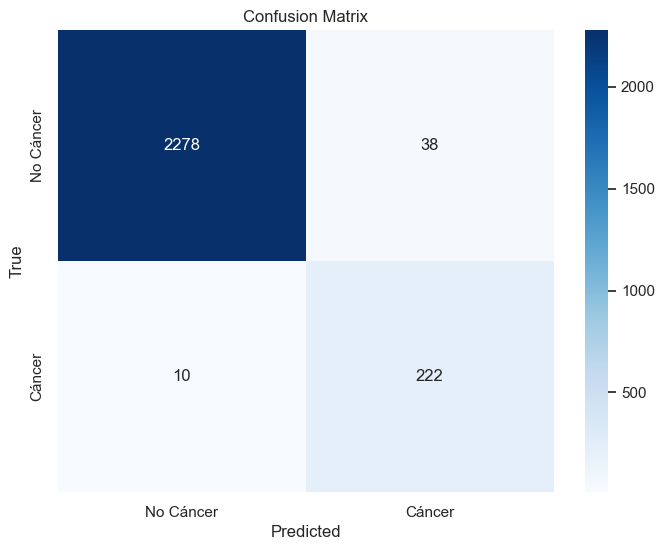

Epoch 10, Training Loss: 0.0377
Validation Loss: 0.0313
F1 Score: 0.9816, Precision: 0.9827, Recall: 0.9812


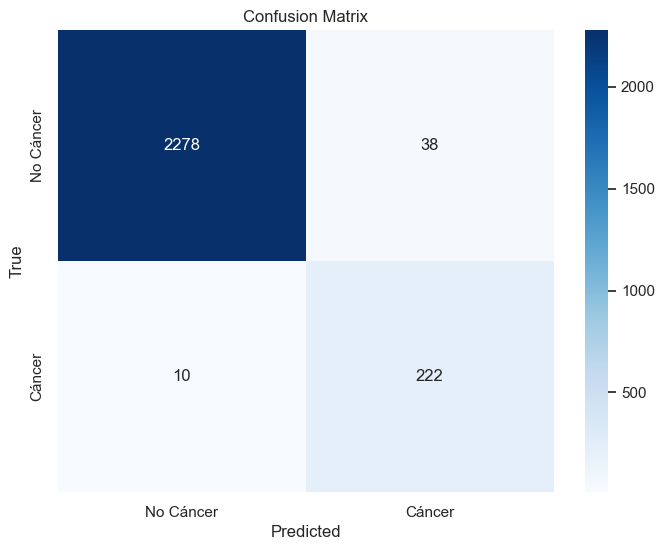

Validation Loss: 0.0302
F1 Score: 0.9843, Precision: 0.9842, Recall: 0.9843


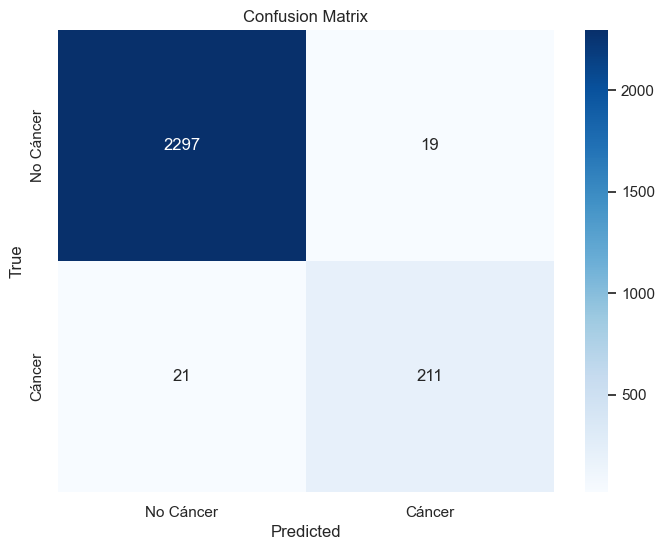

Epoch 11, Training Loss: 0.0367
Validation Loss: 0.0302
F1 Score: 0.9843, Precision: 0.9842, Recall: 0.9843


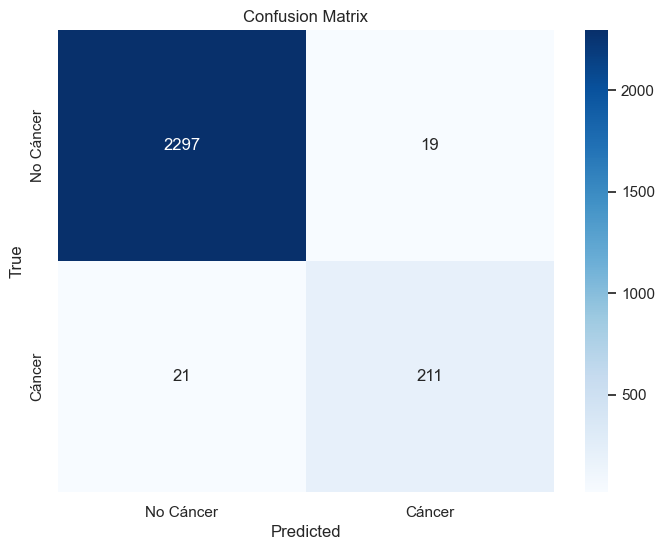

Validation Loss: 0.0313
F1 Score: 0.9819, Precision: 0.9819, Recall: 0.9819


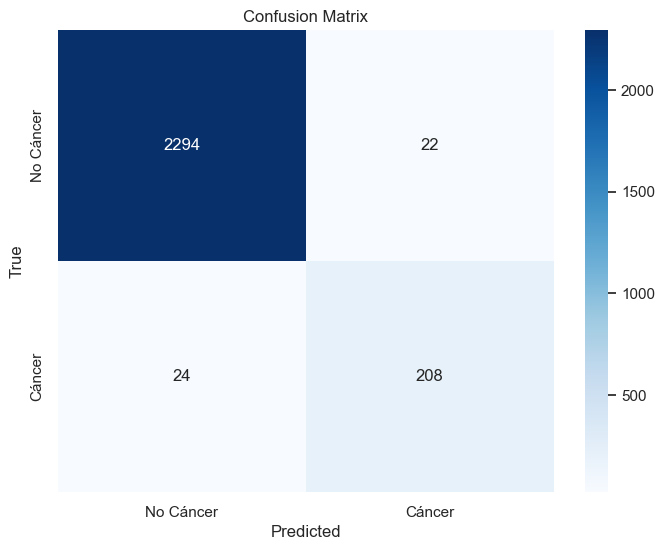

Epoch 12, Training Loss: 0.0358
Validation Loss: 0.0313
F1 Score: 0.9819, Precision: 0.9819, Recall: 0.9819


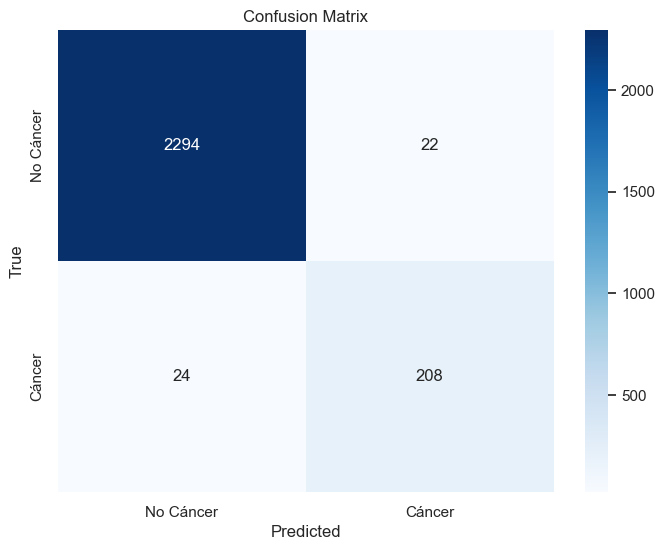

Validation Loss: 0.0293
F1 Score: 0.9848, Precision: 0.9849, Recall: 0.9847


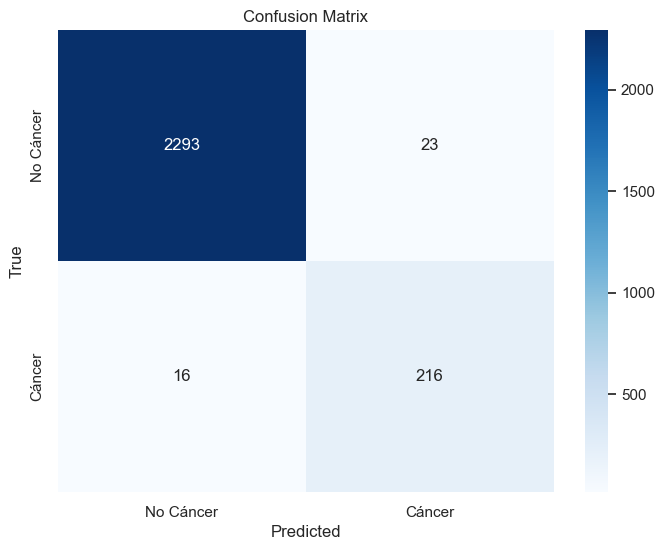

Epoch 13, Training Loss: 0.0354
🔽 Model saved with F1-Score: 0.9848
Validation Loss: 0.0293
F1 Score: 0.9848, Precision: 0.9849, Recall: 0.9847


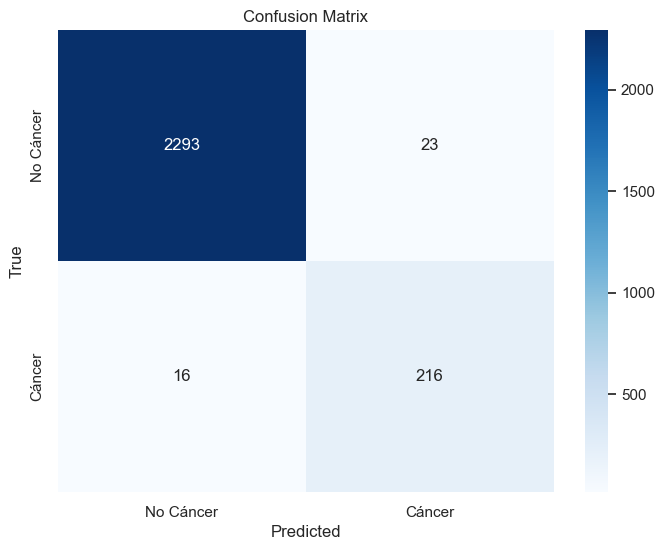

Validation Loss: 0.0296
F1 Score: 0.9822, Precision: 0.9826, Recall: 0.9819


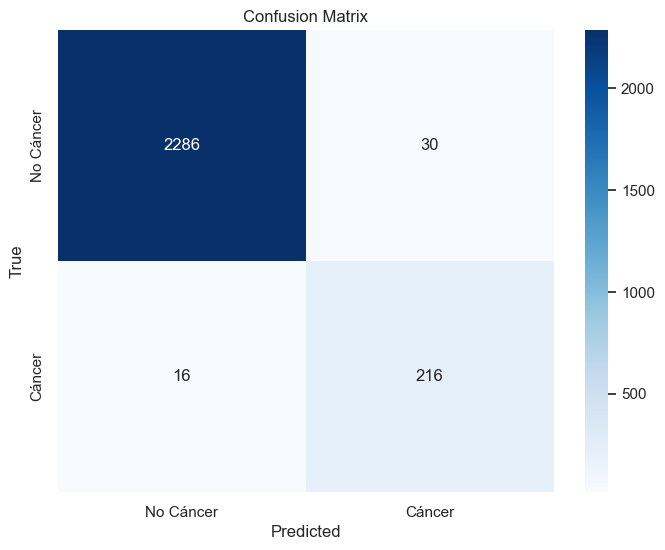

Epoch 14, Training Loss: 0.0357
Validation Loss: 0.0296
F1 Score: 0.9822, Precision: 0.9826, Recall: 0.9819


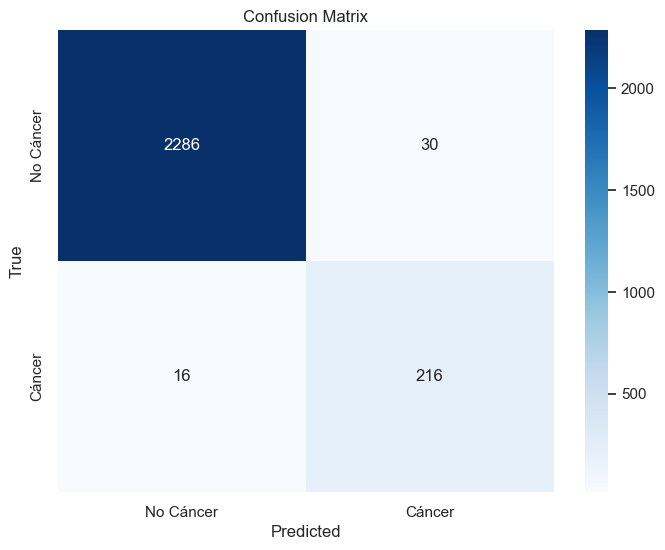

Validation Loss: 0.0300
F1 Score: 0.9834, Precision: 0.9839, Recall: 0.9831


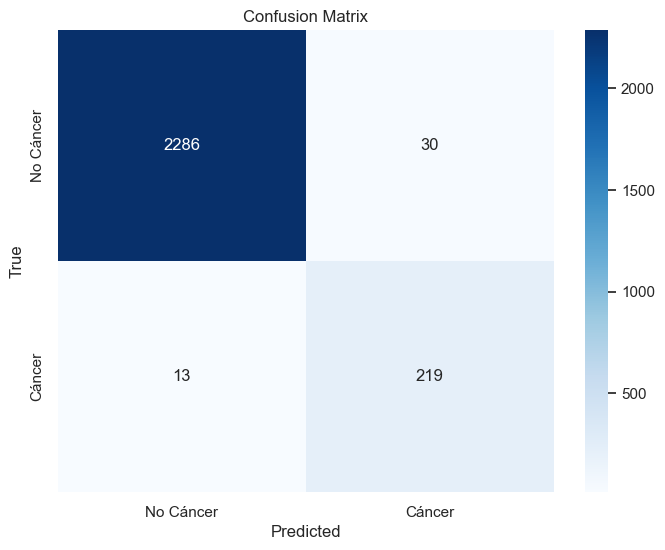

Epoch 15, Training Loss: 0.0352
Validation Loss: 0.0300
F1 Score: 0.9834, Precision: 0.9839, Recall: 0.9831


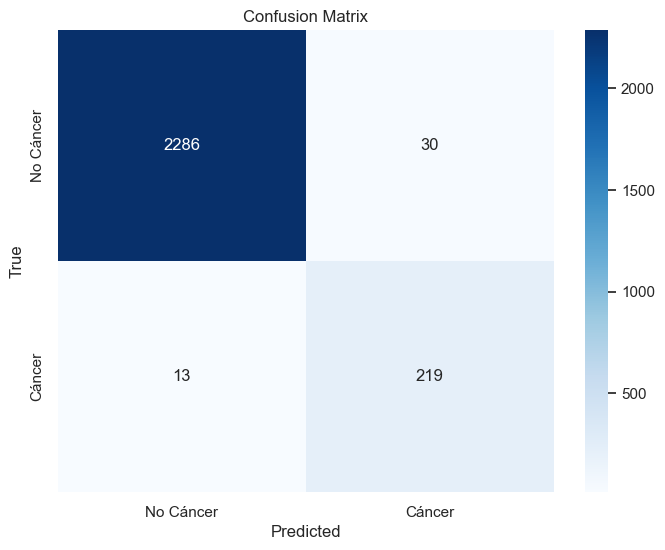

Validation Loss: 0.0295
F1 Score: 0.9847, Precision: 0.9847, Recall: 0.9847


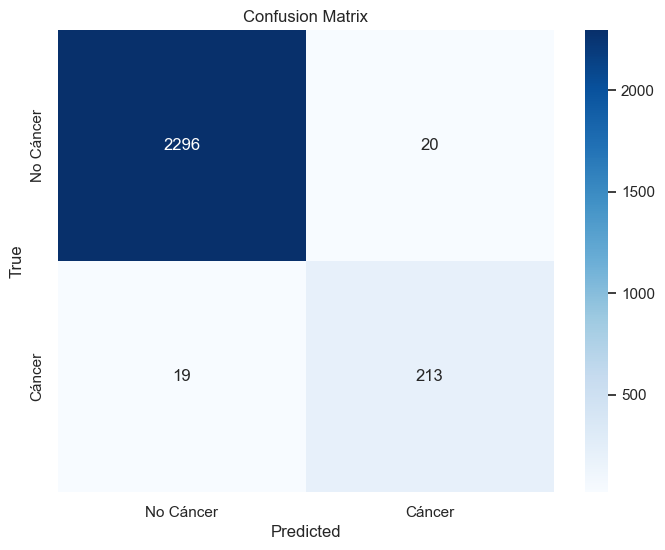

Epoch 16, Training Loss: 0.0358
Validation Loss: 0.0295
F1 Score: 0.9847, Precision: 0.9847, Recall: 0.9847


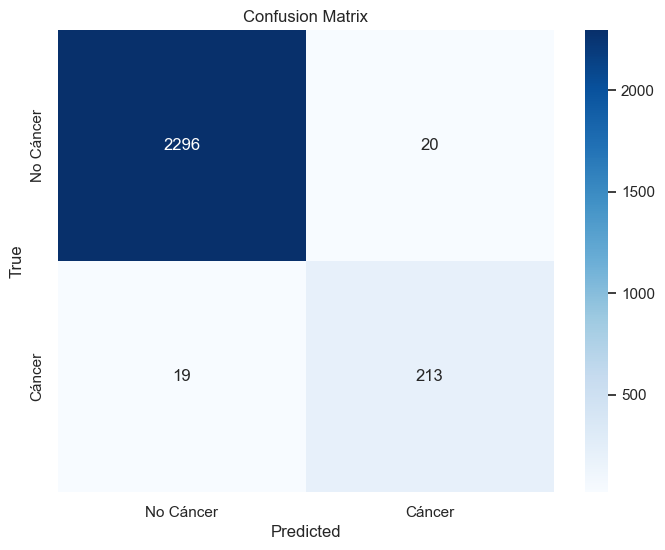

Validation Loss: 0.0299
F1 Score: 0.9860, Precision: 0.9861, Recall: 0.9859


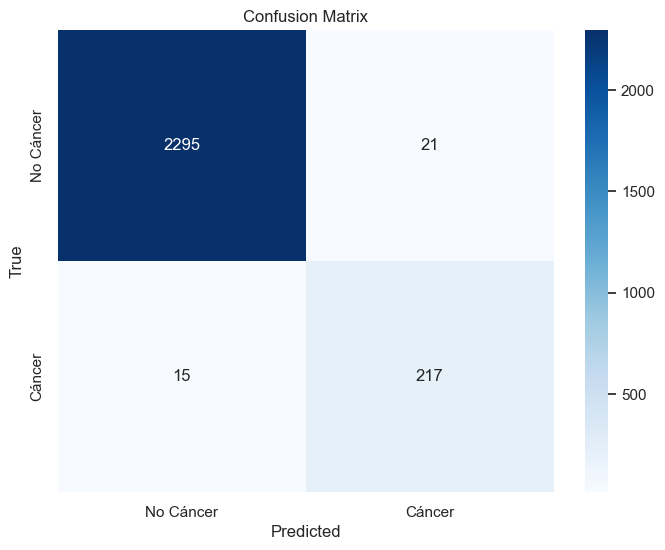

Epoch 17, Training Loss: 0.0351
🔽 Model saved with F1-Score: 0.9860
Validation Loss: 0.0299
F1 Score: 0.9860, Precision: 0.9861, Recall: 0.9859


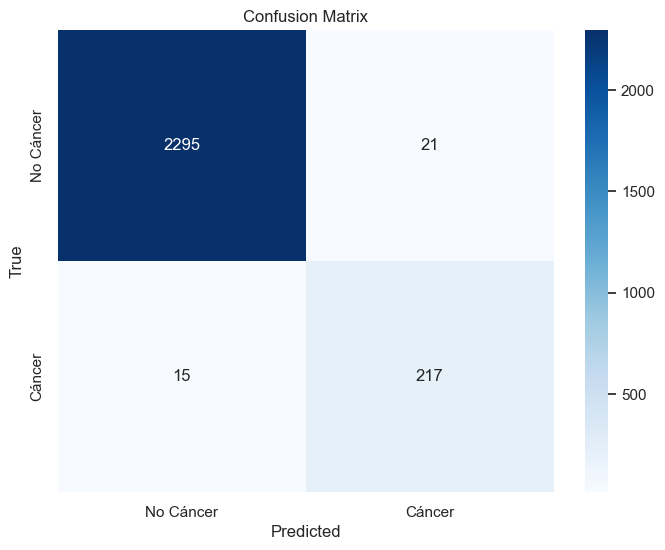

Validation Loss: 0.0308
F1 Score: 0.9812, Precision: 0.9823, Recall: 0.9808


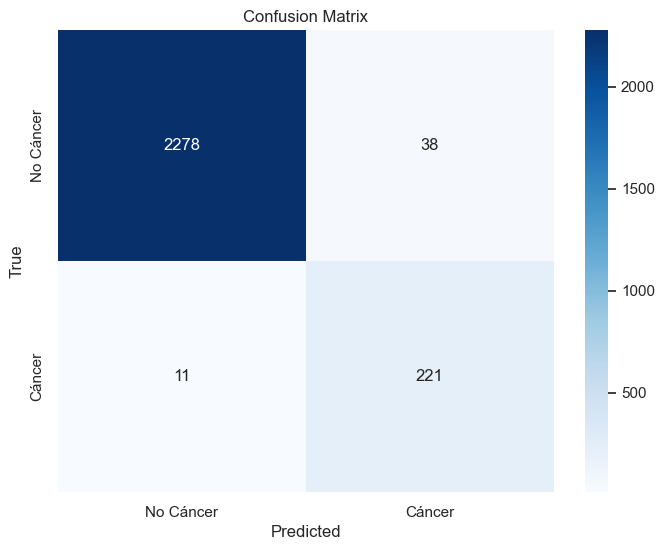

Epoch 18, Training Loss: 0.0366
Validation Loss: 0.0308
F1 Score: 0.9812, Precision: 0.9823, Recall: 0.9808


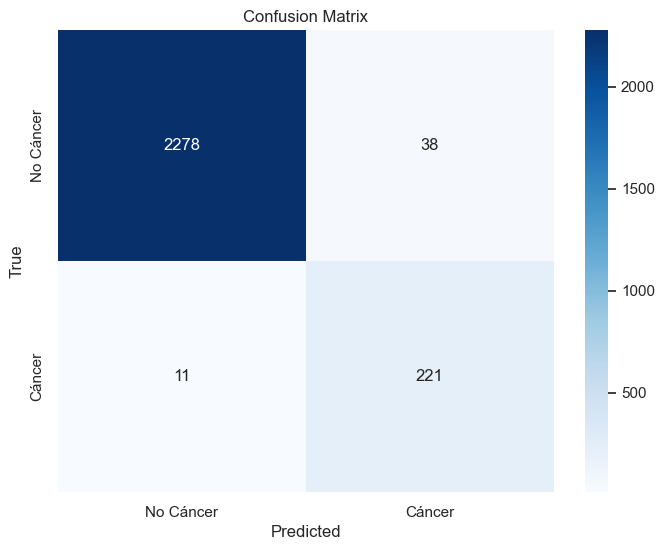

Validation Loss: 0.0322
F1 Score: 0.9831, Precision: 0.9838, Recall: 0.9827


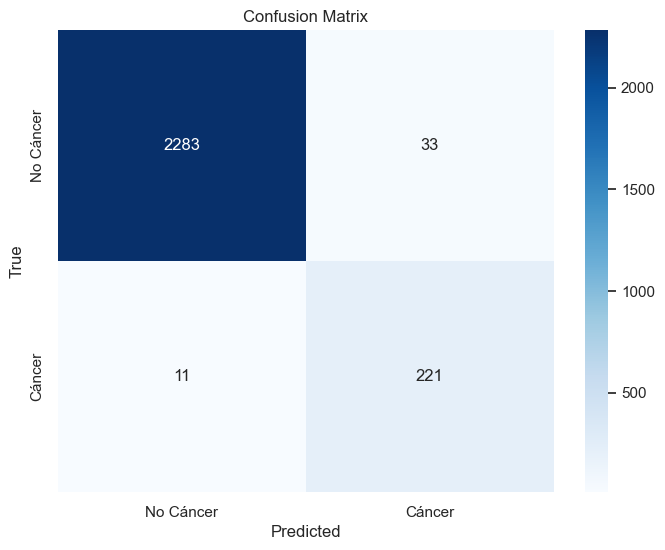

Epoch 19, Training Loss: 0.0355
Validation Loss: 0.0322
F1 Score: 0.9831, Precision: 0.9838, Recall: 0.9827


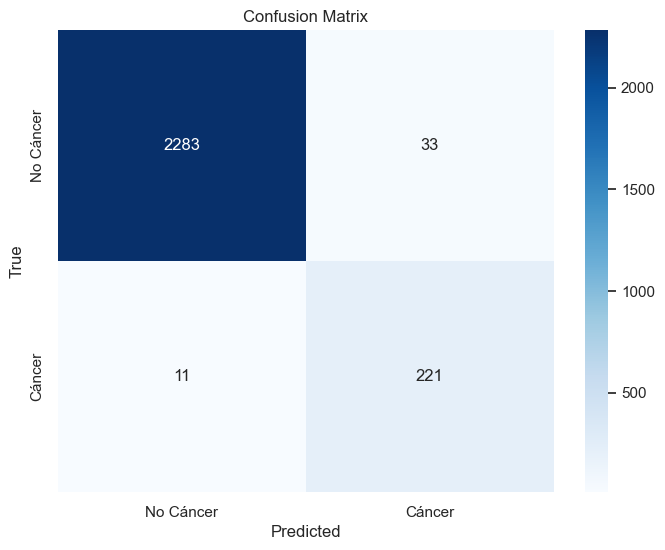

Validation Loss: 0.0291
F1 Score: 0.9845, Precision: 0.9847, Recall: 0.9843


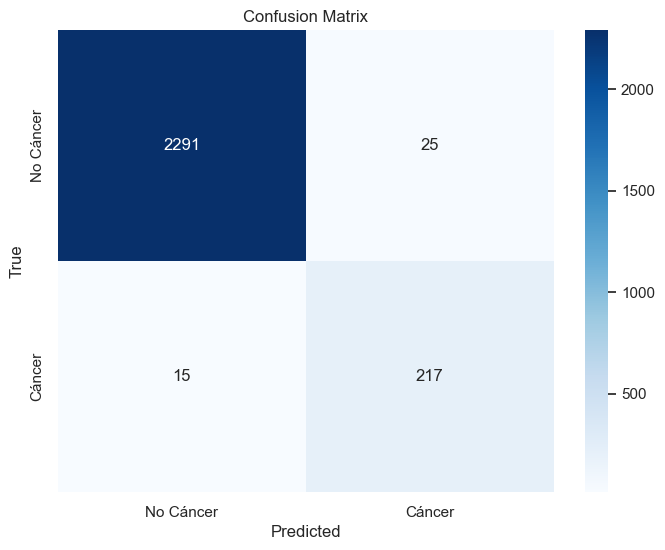

Epoch 20, Training Loss: 0.0367
Validation Loss: 0.0291
F1 Score: 0.9845, Precision: 0.9847, Recall: 0.9843


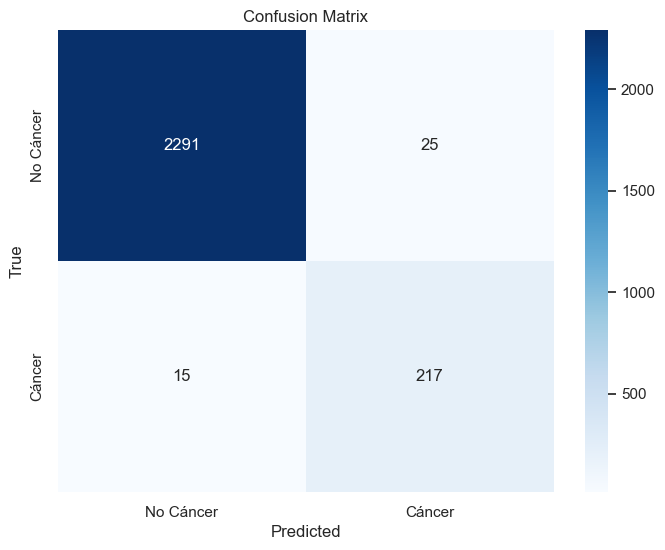

In [ ]:
# Inicializar el modelo
num_features = train_features.shape[1] #
model = CombinedModel(num_features=num_features, num_classes=2).to(device)

# Configurar función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)


In [ ]:
from sklearn.metrics import f1_score

def evaluate_model(model, dataloader, criterion):
    model.eval()  # Modo de evaluación
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch_idx, (images, tabular_data, labels) in enumerate(dataloader):
            # Mover datos al dispositivo (GPU o CPU)
            images = images.to(device)
            tabular_data = tabular_data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images, tabular_data)
            loss = criterion(outputs, labels)

            # Acumular pérdida
            running_loss += loss.item()

            # Predicciones y etiquetas verdaderas
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular métricas
    average_loss = running_loss / len(dataloader)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    return average_loss, f1


In [56]:
test_loss, test_f1 = evaluate_model(model, val_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}")

Test Loss: 0.0291, Test F1: 0.9845


In [57]:
torch.save(model.state_dict(), "cancer_classification_model_final.pth")